<h1> Hemolysis </h1>

In [ ]:
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

torch.cuda.is_available()
torch.cuda.get_device_name(0)

In [25]:
def process(txt):
  split = ' '.join(txt)
  return split

[Text(0, 0, 'High'), Text(0, 1, 'Medium'), Text(0, 2, 'Low')]

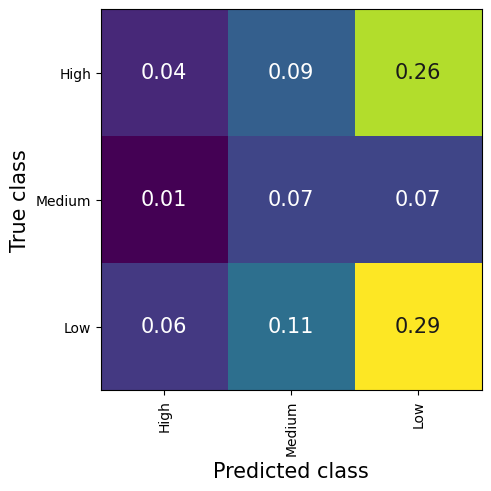

In [152]:
from torchmetrics.classification import MulticlassConfusionMatrix
from torch import tensor

true = encoder.fit_transform(data_1.ACTIVITY)
true_tnr = tensor(true)
metric = MulticlassConfusionMatrix(num_classes=3,normalize = 'all')
metric.update(predictions,true_tnr)
fig_, ax_ = metric.plot()
ax_.set_xticklabels(class_names,
                    rotation=90)
ax_.set_yticklabels(class_names,
                    rotation=0)

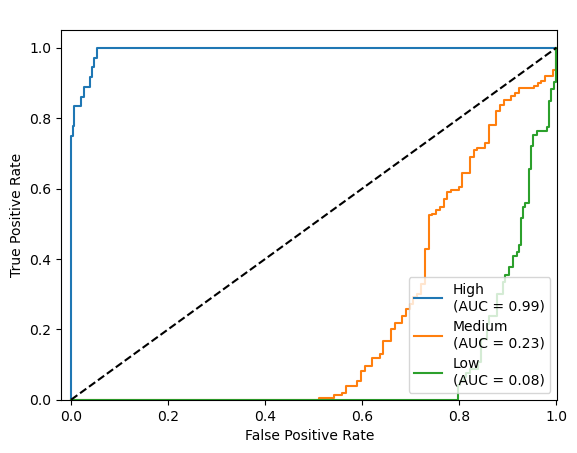

In [156]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from torchmetrics.classification import ROC, AUROC


roc = ROC(task='multilabel', num_labels=3)
auc = AUROC(task='multilabel', num_labels=3, average=None)

fpr, tpr, thresholds = roc(outputs[0], true_bin)
roc_auc = auc(outputs[0], true_bin)

# Plot the ROC curves
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=['High','Medium','Low'][i] + '\n(AUC = %0.2f)' % roc_auc[i])  # + ' (AUC = %0.2f)' % roc_auc[i]

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.02, 1.002])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' ')
plt.legend(loc="lower right")
plt.show()

In [120]:
from torch import rand, randint
from torchmetrics.classification import MultilabelROC

metric = MultilabelROC(num_labels=3)
metric.update(outputs[0], true_bin)
fig_, ax_ = metric.plot(score=True)

C:\Users\avima\AppData\Local\Temp\ipykernel_38676\201514581.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_.show()


In [3]:
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4080'

# finetuned BERT

In [ ]:
from transformers import BertModel, BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
encoded_data = tokenizer.batch_encode_plus(df.processed.values,return_attention_mask=True,padding=True,return_tensors='pt')
input_ids = encoded_data['input_ids'].to('cuda')
attention_masks = encoded_data['attention_mask'].to('cuda')
labels= torch.tensor(df.lab.values, dtype=torch.long).to('cuda')

model = BertForSequenceClassification.from_pretrained("Rostlab/prot_bert",num_labels=3,output_attentions=False)
model.to('cuda')
batch_size =100
epochs =50
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-5)

acc=[]
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    for i in range(0, input_ids.size(0),batch_size):
        optimizer.zero_grad()
        outputs = model(input_ids[i:i+batch_size],attention_mask=attention_masks[i:i+batch_size],labels=labels[i:i+batch_size])
        loss = outputs.loss
        loss.backward()
        optimizer.step()
    epoch_time = time.time() - start_time
    eta = epoch_time * (epochs - epoch - 1)
    with torch.no_grad():
        outputs =  model(input_ids,attention_mask=attention_masks)
        predictions = torch.argmax(outputs[0],dim=1).flatten()
        accuracy =torch.sum(predictions == labels)/len(labels)
        acc.append(accuracy.int())
       
   
    print(f'Epoch [{epoch+1}/{epochs}], ETA: {eta:.2f}s, Accuracy: {accuracy:.2f}')
   
    # add a list here get index[-2]

In [ ]:
# saving the model
f = 'model/tuned_protbert_srt15_EPC50.pth'
torch.save(model.state_dict(),f)

In [45]:
# testing the model
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn import metrics

model = BertForSequenceClassification.from_pretrained("Rostlab/prot_bert",num_labels=3,output_attentions=False)
model_state_dict = torch.load('models/tuned_protbert_EPC50.pth')
model.load_state_dict(model_state_dict, strict=False)
labels= torch.tensor(test.lab,dtype=torch.int64)

model.eval()
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
encoded_data = tokenizer.batch_encode_plus(test.processed,return_attention_mask=True,padding=True,return_tensors='pt')
input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']

with torch.no_grad():
        outputs =  model(input_ids,attention_mask=attention_masks)
        predictions = torch.argmax(outputs[0],dim=1).flatten()

predictions = predictions.numpy()
#acc = F.binary_accuracy(predictions,labels)
#prs = F.binary_precision(predictions,labels)
#prs = binary_precision(predictions,labels)
#class_names = ["High", "Medium", "Low"]
#final_labels = [class_names[i] for i in predictions]
#print(predictions)
#print(acc)
acc = metrics.accuracy_score(predictions,test.lab)
prs = metrics.precision_score(predictions, test.lab, average='macro')
rcl = metrics.precision_score(predictions, test.lab, average='macro')
F1 = metrics.f1_score(predictions, test.lab, average='macro')
jac = metrics.jaccard_score(predictions, test.lab, average='macro')
loss = metrics.hamming_loss(predictions, test.lab)

print(acc,prs,rcl,F1,jac,loss)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Rostlab/prot_bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\avima\AppData\Local\Temp\ipykernel_36800\279708127.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializa

0.5603715170278638 0.5245513606832947 0.5245513606832947 0.523327124257898 0.35880490458551845 0.43962848297213625


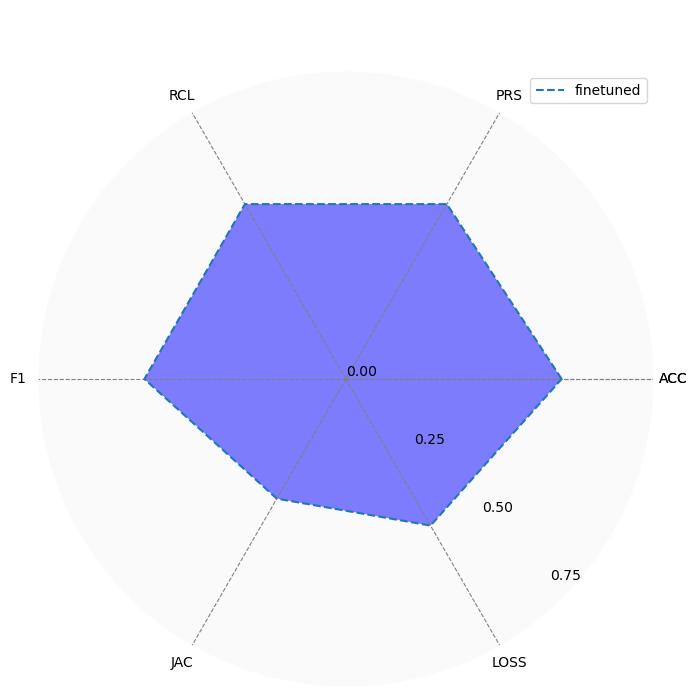

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#met = pd.read_csv('protBERT_plus_ref_metrics.csv')
#met = met[met.columns[1:]]

categories = ['ACC', 'PRS', 'RCL', 'F1','JAC','LOSS']
categories = [*categories, categories[0]]

mdl_1 = [acc,prs,rcl,F1,jac,loss]


mdl_1 = [*mdl_1, mdl_1[0]]


label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(mdl_1))

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(polar=True)
rad = (0,0.25,0.50,0.75)
ax.set_ylim(0,0.8)
ax.set_rgrids(rad,angle= -45)
ax.xaxis.grid(True,color='gray',linestyle='--')



plt.plot(label_loc, mdl_1,linestyle='--',marker=' ',label='finetuned')
plt.fill(label_loc, mdl_1, 'b',alpha=0.5)



plt.title(' ', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
ax.spines['polar'].set_color('w')
ax.grid(which='major', axis='y', linestyle='--', color='#ededed', linewidth=0.00001)
ax.set_facecolor('#FAFAFA')
plt.legend()
plt.show()

In [31]:
print(predictions.size(),labels.size())

torch.Size([323]) torch.Size([323])


# Physiochemical models

In [7]:
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4080'

## Binary

### Data

In [9]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import peptides
from pyteomics.electrochem import gravy

#data = pd.read_excel('DRAMP_FINAL.xlsx',sheet_name = 'Sheet3')
data = pd.read_excel('mammals_hemolysis_compiled.xlsx',sheet_name = 'Sheet2')
seqs = data.SEQUENCE

desc = pd.DataFrame([ peptides.Peptide(s).descriptors() for s in seqs ])

mol_wt = [ProteinAnalysis(s).molecular_weight() for s in seqs]
arom = [ProteinAnalysis(s).aromaticity() for s in seqs]
iso = [ProteinAnalysis(s).isoelectric_point() for s in seqs]
chrg = [ProteinAnalysis(s).charge_at_pH(7.0) for s in seqs]
#ss = [ProteinAnalysis(s).secondary_structure_fraction() for s in seqs]
#me = [ProteinAnalysis(s).molar_extinction_coefficient() for s in seqs]
#act = raw_data['ACTIVITY']
#flx = [ProteinAnalysis(s).flexibility() for s in seqs]
'''
gr = [gravy(s,
           hydropathicity={'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 
                           'F': 2.8, 'G': -0.4, 'H': -3.2, 'I': 4.5, 
                           'K': -3.9, 'L': 3.8, 'M': 1.9, 'N': -3.5,
                           'P': -1.6, 'Q': -3.5, 'R': -4.5, 'S': -0.8, 
                           'T': -0.7, 'V': 4.2, 'W': -0.9, 'Y': -1.3, 'O':0.0}
           ) for s in seqs]
'''

#inst = [ProteinAnalysis(s).instability_index() for s in seqs]

desc['Sequence']=seqs
desc['mol_wt'] = mol_wt
desc['arom'] = arom
desc['iso'] = iso
desc['chrg'] = chrg
desc['lab'] = data.bin_labels
#desc['me'] = me
#desc['ss'] = ss
#desc['Act'] = act
#desc['flx'] = flx
#desc['gravy'] = gr
#desc['inst'] = inst

#desc.to_csv('peptide_seq_wmw.csv')
np.shape(desc)
desc.head()

,AF1,AF2,AF3,AF4,AF5,BLOSUM1,BLOSUM2,BLOSUM3,BLOSUM4,BLOSUM5,...,Z2,Z3,Z4,Z5,Sequence,mol_wt,arom,iso,chrg,lab
0,0.070524,-0.124583,0.690970,0.418228,0.739378,-0.130385,-0.251154,-0.380385,-0.180385,0.114231,...,-0.190769,-1.286923,0.271923,0.147692,RVKRVWPLVIRTVIAGYNLYRAIKKK,3141.8444,0.115385,11.603681,7.754068,High
1,-0.139976,-0.064296,0.217738,0.283138,0.299840,-0.060000,-0.229524,-0.069524,-0.088095,-0.077619,...,-0.800000,-0.560000,-0.229524,0.172857,GIWDTIKSMGKVFAGKILQNL,2319.7631,0.095238,9.703024,1.758225,Low
2,0.599919,-0.025275,-0.281669,-0.305115,0.532585,0.634167,0.604583,-0.348750,0.362083,0.293750,...,0.839167,-0.470000,1.241250,0.007500,DSHAKRHHGYKRKFHEKHHSHRGY,3036.2934,0.125000,10.283368,5.368228,Low
3,-0.224297,-0.470157,-0.039943,0.821174,0.422599,0.032381,-0.587619,0.059048,-0.136190,0.095714,...,-1.659524,-0.523810,-0.042857,0.527143,GMASKAGAIAGKIAKVALKAL,1969.4384,0.000000,10.477740,3.756106,Low
4,-0.071970,-0.756284,-0.298431,0.683921,0.148584,-0.218667,-0.464000,-0.258667,-0.376000,0.260000,...,-0.786667,-1.039333,0.243333,0.519333,ALWKTLLKKVLKAAA,1654.0913,0.066667,10.477869,3.791879,High


In [11]:
### Train dataset ###

import numpy as np
import pandas as pd
from sklearn import preprocessing


encoder = preprocessing.LabelEncoder()
#data = pd.read_csv("peptide_seq_wmw.csv")

X = desc.iloc[:,desc.columns!='lab']
#X['emb'] = X['Sequence'].apply(lambda x: get_embeddings(x))
#X['emb'] = np.vectorize(X['emb'])
X.pop('Sequence')
#X.pop('ss')
#X.pop('me')

y = encoder.fit_transform(desc['lab'])

np.shape(X), np.shape(y)

((2665, 106), (2665,))

In [13]:
y = encoder.fit_transform(desc['lab'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)
np.shape(X_train)

(2132, 106)

### Support Vector Machine

In [15]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pickle
import shap

# Create the training and test sets
#X_train, X_test, y_train, y_test = train_test_split(x_n1, y, test_size=0.1, random_state=42)
# Instantiate the classifier: dt_clf_4
clf_5 = SVC(probability=True)

# Fit the classifier to the training set
clf_5.fit(X_train,y_train)

# Predict the labels of the test set: y_pred_4
y_pred_5 = clf_5.predict(X_test)

# Compute the accuracy of the predictions: accuracy
accuracy_svm = metrics.accuracy_score(y_test,y_pred_5)#float(np.sum(y_pred_4==y_test))/y_test.shape[0]
mcc_svm = metrics.matthews_corrcoef(y_test,y_pred_5)
F1_svm = metrics.f1_score(y_test,y_pred_5,average = 'macro')
recall_svm = metrics.recall_score(y_test,y_pred_5,average = 'macro')
precision_svm = metrics.precision_score(y_test,y_pred_5,average = 'macro')
jaccard_svm = metrics.jaccard_score(y_test,y_pred_5,average = 'macro')
loss_svm = metrics.hamming_loss(y_test,y_pred_5)



# Cross validation
k_folds = KFold(n_splits = 5)
scores_5 = cross_val_score(clf_5, X_train, y_train, cv = k_folds)
print("Xval:", scores_5)
print("accuracy:", accuracy_svm)
print("mcc:", mcc_svm)
print("F1:", F1_svm)
print("recall:", recall_svm)
print("precision:", precision_svm)
print("jaccard:", jaccard_svm)
print("loss:", loss_svm)
print(y_pred_5)

# Saving Model
pickle.dump(clf_5,open("model/physiochemical/SVM_hemo_bin.pkl","wb"))

C:\Users\mdlab_2\anaconda3\envs\torch_LSTM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Xval: [0.53395785 0.54098361 0.48591549 0.5258216  0.54694836]
accuracy: 0.551594746716698
mcc: 0.15126566770171465
F1: 0.4327085365147649
recall: 0.53595697287543
precision: 0.6590880738522954
jaccard: 0.3121122643760439
loss: 0.44840525328330205
[1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0
 1

In [ ]:
import shap

explainer = shap.Explainer(clf_1)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[0], X_test)

In [ ]:
shap.dependence_plot("Subscription Length", shap_values[0], X_test,interaction_index="Age")

### XGboost 1vsRest

In [17]:
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import PrecisionRecallDisplay
import pickle


# Create the training and test sets
#X_train, X_test, y_train, y_test = train_test_split(x_n1, y, test_size=0.1, random_state=42)

# Instantiate the classifier: dt_clf_4
clf_1 = XGBClassifier(max_depth=6)

# Fit the classifier to the training set
clf_1.fit(X_train,y_train)

# Predict the labels of the test set: y_pred_4
y_pred_1 = clf_1.predict(X_test)

# Compute the accuracy of the predictions: accuracy
accuracy_xgb = metrics.accuracy_score(y_test,y_pred_1)
#auc_score_xgb = metrics.roc_auc_score(y_test,y_pred_1)
mcc_xgb = metrics.matthews_corrcoef(y_test,y_pred_1)
F1_xgb = metrics.f1_score(y_test,y_pred_1,average = 'macro')
recall_xgb = metrics.recall_score(y_test,y_pred_1,average = 'macro')
precision_xgb = metrics.precision_score(y_test,y_pred_1,average = 'macro')
jaccard_xgb = metrics.jaccard_score(y_test,y_pred_1,average = 'macro')
loss_xgb = metrics.hamming_loss(y_test,y_pred_1)

#cross-validation
k_folds = KFold(n_splits = 5)
scores_1 = cross_val_score(clf_1, X_train, y_train, cv = k_folds)
print("Xval:", scores_1)
print("accuracy:", accuracy_xgb)
print("mcc:", mcc_xgb)
#print("auc:", auc_score_xgb)
print("F1:", F1_xgb)
print("recall:", recall_xgb)
print("precision:", precision_xgb)
print("jaccard:", jaccard_xgb)
print("loss:", loss_xgb)
#print(y_pred_1)



# Saving Model
pickle.dump(clf_1,open("model/physiochemical/XGBT_hemo_bin.pkl","wb"))

Xval: [0.71428571 0.74004684 0.71361502 0.70657277 0.6971831 ]
accuracy: 0.7335834896810507
mcc: 0.46847344694550264
F1: 0.7335750492818924
recall: 0.7343159645858004
precision: 0.7341575091575092
jaccard: 0.5792509481668773
loss: 0.26641651031894936


### Catboost

In [19]:
from catboost import CatBoostClassifier, cv
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn import metrics, preprocessing
import numpy as np
import pandas as pd
import pickle

#X_train, X_test, y_train, y_test = train_test_split(x_n1, y, test_size=0.1, random_state=42)

cat = CatBoostClassifier(iterations=200,
                           #loss_function='MultiClassOneVsAll',
                           custom_loss=['Accuracy','Precision'],
                           early_stopping_rounds=20,
                           task_type='GPU',
                           l2_leaf_reg=0.25,verbose= False,
                           learning_rate=0.01,depth=10,random_seed = 42)



# Fit the classifier to the training set
cat.fit(X_train,y_train)
 

# Predict the labels of the test set: y_pred_4
y_pred_2 = cat.predict(X_test)


#k_folds = KFold(n_splits = 5)
#scores_cat = cross_val_score(cat, X, y, cv = k_folds)
#print("Xval:", scores_cat)

param = {
    'loss_function': 'MultiClassOneVsAll',
    'iterations': 80,
    'custom_loss': ['Accuracy','Precision'],
    'learning_rate': 0.01
}

#cv = cv(params = param,fold_count = 5)
accuracy_cat = metrics.accuracy_score(y_test,y_pred_2)#float(np.sum(y_pred_4==y_test))/y_test.shape[0]
mcc_cat = metrics.matthews_corrcoef(y_test,y_pred_2)
F1_cat = metrics.f1_score(y_test,y_pred_2,average = 'macro')
recall_cat = metrics.recall_score(y_test,y_pred_2,average = 'macro')
precision_cat = metrics.precision_score(y_test,y_pred_2,average = 'macro')
jaccard_cat = metrics.jaccard_score(y_test,y_pred_2,average = 'macro')
loss_cat = metrics.hamming_loss(y_test,y_pred_2)
#pred_lab = (list(encoder.inverse_transform(y_pred_2)))
#auc_score_cat = metrics.roc
#print("Xval:", cv)

print("accuracy:", accuracy_cat)
print("mcc:", mcc_cat)
print("F1:", F1_cat)
print("recall:", recall_cat)
print("precision:", precision_cat)
print("jaccard:", jaccard_cat)
print("loss:", loss_cat)

#print(y_pred_2.tolist())


#save model
pickle.dump(cat,open("model/physiochemical/cat_hemo_bin.pkl","wb"))

accuracy: 0.7373358348968105
mcc: 0.47598514476512155
F1: 0.7373275133765136
recall: 0.7380730840805279
precision: 0.737912087912088
jaccard: 0.5839441844034267
loss: 0.2626641651031895


### metrics

In [21]:
metrics = {'svm': [accuracy_svm,mcc_svm,precision_svm,recall_svm,F1_svm,jaccard_svm,loss_svm],
           'xgb': [accuracy_xgb,mcc_xgb,precision_xgb,recall_xgb,F1_xgb,jaccard_xgb,loss_xgb],
           'cat': [accuracy_cat,mcc_cat,precision_cat,recall_cat,F1_cat,jaccard_cat,loss_cat]}
metrics = pd.DataFrame.from_dict(metrics)
metrics.index = ['acc','mcc','prs','rcl','F1','jac','loss']
#metrics['met'] = ['acc','F1','rcl','prs']
metrics = metrics.T
metrics.to_csv('model/physiochemical/hemo_ref_models_bin.csv')
metrics.head()

,acc,F1,rcl,prs,jac,loss,mcc
svm,0.551595,0.432709,0.535957,0.659088,0.312112,0.448405,0.151266
xgb,0.733583,0.733575,0.734316,0.734158,0.579251,0.266417,0.468473
cat,0.737336,0.737328,0.738073,0.737912,0.583944,0.262664,0.475985


### radar

C:\Users\mdlab_2\AppData\Local\Temp\ipykernel_10356\2359523978.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mdl_1 = [*mdl_1, mdl_1[0]]
C:\Users\mdlab_2\AppData\Local\Temp\ipykernel_10356\2359523978.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mdl_2 = [*mdl_2, mdl_2[0]]
C:\Users\mdlab_2\AppData\Local\Temp\ipykernel_10356\2359523978.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mdl_3 = [*mdl_3, mdl_3[0]]


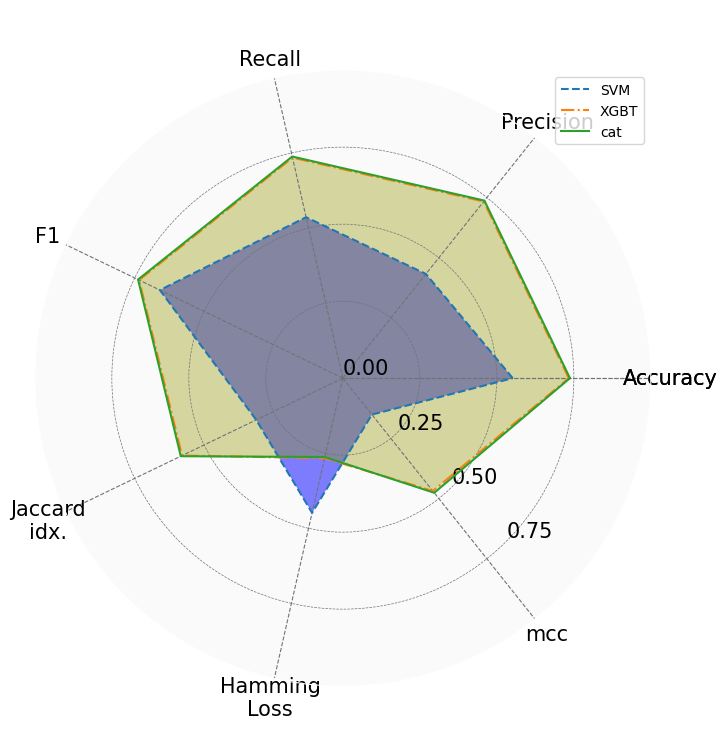

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

met = pd.read_csv('model/physiochemical/hemo_ref_models_bin.csv')
met = met[met.columns[1:]]

categories = ['Accuracy', 'Matthews\ncoef.','Precision', 'Recall', 'F1','Jaccard\nidx.','Hamming\nLoss']
categories = [*categories, categories[0]]

mdl_1 = met.iloc[0]
mdl_2 = met.iloc[1]
mdl_3 = met.iloc[2]

mdl_1 = [*mdl_1, mdl_1[0]]
mdl_2 = [*mdl_2, mdl_2[0]]
mdl_3 = [*mdl_3, mdl_3[0]]

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(mdl_1))

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(polar=True)
rad = (0,0.25,0.50,0.75)
ax.set_ylim(0,1)
ax.set_rgrids(rad,size = 20,angle= -45)
ax.xaxis.grid(True,color='k',linestyle='--',linewidth=0.5)



plt.plot(label_loc, mdl_2, 'orange',alpha=0.45,linestyle='--',marker=' ',label='XGBT')
plt.fill(label_loc, mdl_2, 'orange',alpha=0.75)

plt.plot(label_loc, mdl_3,'#77D970',alpha=0.45,linestyle='--',marker=' ',label='cat')
plt.fill(label_loc, mdl_3, '#77D970',alpha=0.75)

plt.plot(label_loc, mdl_1,'#9C19E0',linestyle='--',marker=' ',label='SVM')
plt.fill(label_loc, mdl_1, '#9C19E0',alpha=0.75)

plt.title(' ', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories, size= 20)
ax.spines['polar'].set_color('#FAFAFA')
ax.grid(which='major', axis='y', linestyle='--', color='k', linewidth=0.5) #ededed
ax.set_facecolor('#FAFAFA')
#plt.legend()
plt.savefig('model/physiochemical/ref_radar_models_hemo_bin.tiff',dpi=600)

plt.show()

### roc curve

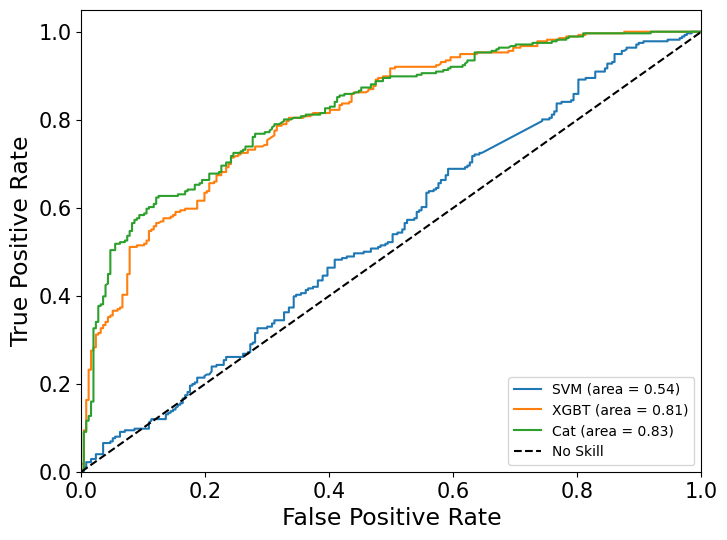

In [25]:
from sklearn.metrics import roc_curve, auc

out_1_p = clf_5.predict_proba(X_test)
out_2_p = clf_1.predict_proba(X_test)
out_3_p = cat.predict_proba(X_test)

fpr_1, tpr_1, thresholds = roc_curve(y_test, out_1_p[:,1]) 
auc_1 = auc(fpr_1, tpr_1)

fpr_2, tpr_2, thresholds = roc_curve(y_test, out_2_p[:,1]) 
auc_2 = auc(fpr_2, tpr_2)

fpr_3, tpr_3, thresholds = roc_curve(y_test, out_3_p[:,1]) 
auc_3 = auc(fpr_3, tpr_3)



# Plot the ROC curve
plt.figure(figsize=(8,6))  
plt.plot(fpr_1, tpr_1, label='SVM (area = %0.2f)' % auc_1)
plt.plot(fpr_2, tpr_2, label='XGBT (area = %0.2f)' % auc_2)
plt.plot(fpr_3, tpr_3, label='Cat (area = %0.2f)' % auc_3)


plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size = 17)
plt.ylabel('True Positive Rate', size = 17)
plt.xticks(size = 15),plt.yticks(size = 15)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('model/physiochemical/fig/ref_models_hemo_roc_bin.tiff',dpi=600)

plt.show()

### confusion matrix

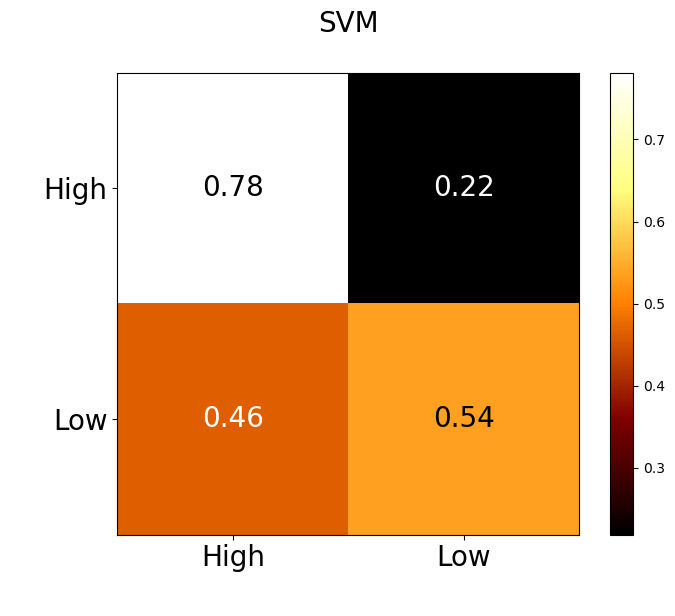

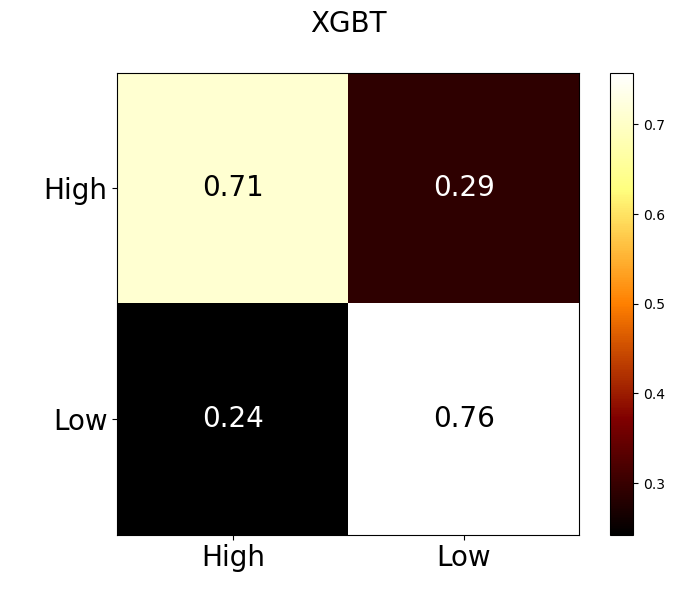

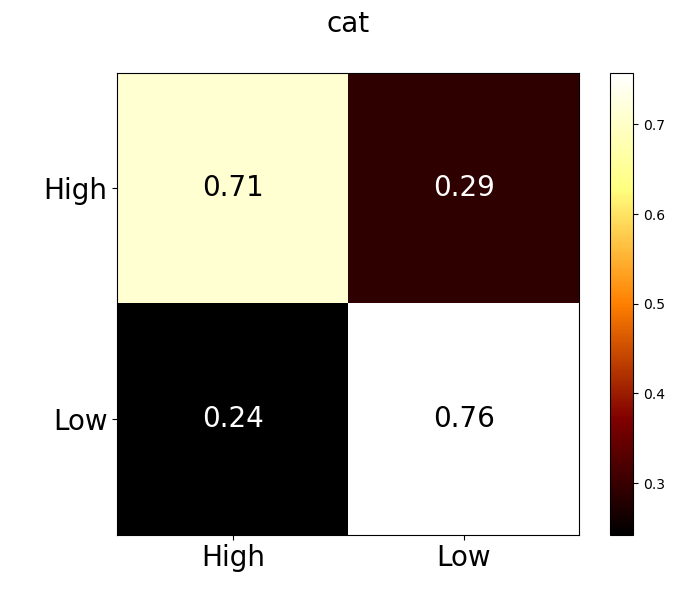

In [27]:
### 2L ###

from sklearn.metrics import ConfusionMatrixDisplay

# xgbt :: afmhot ; svm :: plasma ; cat :: BuGn_r

# SVM
fig,ax = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay.from_predictions(y_pred_5,y_test,ax=ax,
                                        cmap = 'afmhot', normalize='true',
                                       text_kw={'size': 20})
ax.xaxis.set_ticklabels(['High','Low'],size=20,
                       rotation = 0)
ax.yaxis.set_ticklabels(['High','Low'],size=20,
                        rotation = 0)
ax.set_xlabel(' ',size=20)
ax.set_ylabel(' ',size=20)

plt.title('SVM\n',size = 20)
plt.savefig('model/physiochemical/fig/SVM_hemo_cm_bin.tiff',dpi = 600)


# XGBT
fig,ax = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay.from_predictions(y_pred_1,y_test,ax=ax,
                                        cmap = 'afmhot', normalize='true',
                                       text_kw={'size': 20})
ax.xaxis.set_ticklabels(['High','Low'],size=20,
                       rotation = 0)
ax.yaxis.set_ticklabels(['High','Low'],size=20,
                        rotation = 0)
ax.set_xlabel(' ',size=20)
ax.set_ylabel(' ',size=20)

plt.title('XGBT\n',size = 20)
plt.savefig('model/physiochemical/fig/XGBT_hemo_cm_bin.tiff',dpi = 600)

# Cat
fig,ax = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay.from_predictions(y_pred_1,y_test,ax=ax,
                                        cmap = 'afmhot', normalize='true',
                                       text_kw={'size': 20})
ax.xaxis.set_ticklabels(['High','Low'],size=20,
                       rotation = 0)
ax.yaxis.set_ticklabels(['High','Low'],size=20,
                        rotation = 0)
ax.set_xlabel(' ',size=20)
ax.set_ylabel(' ',size=20)

plt.title('cat\n',size = 20)
plt.savefig('model/physiochemical/fig/cat_hemo_cm_bin.tiff',dpi = 600)


## Multi_label

### Data

In [33]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import peptides
from pyteomics.electrochem import gravy

#data = pd.read_excel('DRAMP_FINAL.xlsx',sheet_name = 'Sheet3')
data = pd.read_excel('mammals_hemolysis_compiled.xlsx',sheet_name = 'Sheet2')
seqs = data.SEQUENCE

desc = pd.DataFrame([ peptides.Peptide(s).descriptors() for s in seqs ])

mol_wt = [ProteinAnalysis(s).molecular_weight() for s in seqs]
arom = [ProteinAnalysis(s).aromaticity() for s in seqs]
iso = [ProteinAnalysis(s).isoelectric_point() for s in seqs]
chrg = [ProteinAnalysis(s).charge_at_pH(7.0) for s in seqs]
#ss = [ProteinAnalysis(s).secondary_structure_fraction() for s in seqs]
#me = [ProteinAnalysis(s).molar_extinction_coefficient() for s in seqs]
#act = raw_data['ACTIVITY']
#flx = [ProteinAnalysis(s).flexibility() for s in seqs]
'''
gr = [gravy(s,
           hydropathicity={'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 
                           'F': 2.8, 'G': -0.4, 'H': -3.2, 'I': 4.5, 
                           'K': -3.9, 'L': 3.8, 'M': 1.9, 'N': -3.5,
                           'P': -1.6, 'Q': -3.5, 'R': -4.5, 'S': -0.8, 
                           'T': -0.7, 'V': 4.2, 'W': -0.9, 'Y': -1.3, 'O':0.0}
           ) for s in seqs]
'''

#inst = [ProteinAnalysis(s).instability_index() for s in seqs]

desc['Sequence']=seqs
desc['mol_wt'] = mol_wt
desc['arom'] = arom
desc['iso'] = iso
desc['chrg'] = chrg
desc['lab'] = data.multi_labels
#desc['me'] = me
#desc['ss'] = ss
#desc['Act'] = act
#desc['flx'] = flx
#desc['gravy'] = gr
#desc['inst'] = inst

#desc.to_csv('peptide_seq_wmw.csv')
np.shape(desc)
desc.head()

,AF1,AF2,AF3,AF4,AF5,BLOSUM1,BLOSUM2,BLOSUM3,BLOSUM4,BLOSUM5,...,Z2,Z3,Z4,Z5,Sequence,mol_wt,arom,iso,chrg,lab
0,0.070524,-0.124583,0.690970,0.418228,0.739378,-0.130385,-0.251154,-0.380385,-0.180385,0.114231,...,-0.190769,-1.286923,0.271923,0.147692,RVKRVWPLVIRTVIAGYNLYRAIKKK,3141.8444,0.115385,11.603681,7.754068,High
1,-0.139976,-0.064296,0.217738,0.283138,0.299840,-0.060000,-0.229524,-0.069524,-0.088095,-0.077619,...,-0.800000,-0.560000,-0.229524,0.172857,GIWDTIKSMGKVFAGKILQNL,2319.7631,0.095238,9.703024,1.758225,Medium
2,0.599919,-0.025275,-0.281669,-0.305115,0.532585,0.634167,0.604583,-0.348750,0.362083,0.293750,...,0.839167,-0.470000,1.241250,0.007500,DSHAKRHHGYKRKFHEKHHSHRGY,3036.2934,0.125000,10.283368,5.368228,Medium
3,-0.224297,-0.470157,-0.039943,0.821174,0.422599,0.032381,-0.587619,0.059048,-0.136190,0.095714,...,-1.659524,-0.523810,-0.042857,0.527143,GMASKAGAIAGKIAKVALKAL,1969.4384,0.000000,10.477740,3.756106,Medium
4,-0.071970,-0.756284,-0.298431,0.683921,0.148584,-0.218667,-0.464000,-0.258667,-0.376000,0.260000,...,-0.786667,-1.039333,0.243333,0.519333,ALWKTLLKKVLKAAA,1654.0913,0.066667,10.477869,3.791879,High


In [35]:
### Train dataset ###

import numpy as np
import pandas as pd
from sklearn import preprocessing


encoder = preprocessing.LabelEncoder()
#data = pd.read_csv("peptide_seq_wmw.csv")

X = desc.iloc[:,desc.columns!='lab']
#X['emb'] = X['Sequence'].apply(lambda x: get_embeddings(x))
#X['emb'] = np.vectorize(X['emb'])
X.pop('Sequence')
#X.pop('ss')
#X.pop('me')

y = encoder.fit_transform(desc['lab'])

np.shape(X), np.shape(y)

((2665, 106), (2665,))

In [37]:
y = encoder.fit_transform(desc['lab'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)
np.shape(X_train)

(2132, 106)

### Support Vector Machine

In [39]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pickle
import shap

# Create the training and test sets
#X_train, X_test, y_train, y_test = train_test_split(x_n1, y, test_size=0.1, random_state=42)
# Instantiate the classifier: dt_clf_4
clf_5 = SVC(probability=True)

# Fit the classifier to the training set
clf_5.fit(X_train,y_train)

# Predict the labels of the test set: y_pred_4
y_pred_5 = clf_5.predict(X_test)

# Compute the accuracy of the predictions: accuracy
accuracy_svm = metrics.accuracy_score(y_test,y_pred_5)#float(np.sum(y_pred_4==y_test))/y_test.shape[0]
mcc_svm = metrics.matthews_corrcoef(y_test,y_pred_5)
F1_svm = metrics.f1_score(y_test,y_pred_5,average = 'macro')
recall_svm = metrics.recall_score(y_test,y_pred_5,average = 'macro')
precision_svm = metrics.precision_score(y_test,y_pred_5,average = 'macro')
jaccard_svm = metrics.jaccard_score(y_test,y_pred_5,average = 'macro')
loss_svm = metrics.hamming_loss(y_test,y_pred_5)



# Cross validation
k_folds = KFold(n_splits = 5)
scores_5 = cross_val_score(clf_5, X_train, y_train, cv = k_folds)
print("Xval:", scores_5)
print("accuracy:", accuracy_svm)
print("mcc:", mcc_svm)
print("F1:", F1_svm)
print("recall:", recall_svm)
print("precision:", precision_svm)
print("jaccard:", jaccard_svm)
print("loss:", loss_svm)
print(y_pred_5)

# Saving Model
pickle.dump(clf_5,open("model/physiochemical/SVM_hemo_3L.pkl","wb"))

C:\Users\mdlab_2\anaconda3\envs\torch_LSTM\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Xval: [0.56908665 0.5971897  0.53755869 0.59859155 0.58215962]
accuracy: 0.5722326454033771
mcc: 0.0
F1: 0.24264120922832141
recall: 0.3333333333333333
precision: 0.19074421513445905
jaccard: 0.19074421513445905
loss: 0.4277673545966229
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 

### XGboost

In [41]:
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import PrecisionRecallDisplay
import pickle


# Create the training and test sets
#X_train, X_test, y_train, y_test = train_test_split(x_n1, y, test_size=0.1, random_state=42)

# Instantiate the classifier: dt_clf_4
clf_1 = XGBClassifier(max_depth=6)

# Fit the classifier to the training set
clf_1.fit(X_train,y_train)

# Predict the labels of the test set: y_pred_4
y_pred_1 = clf_1.predict(X_test)

# Compute the accuracy of the predictions: accuracy
accuracy_xgb = metrics.accuracy_score(y_test,y_pred_1)
#auc_score_xgb = metrics.roc_auc_score(y_test,y_pred_1)
mcc_xgb = metrics.matthews_corrcoef(y_test,y_pred_1)
F1_xgb = metrics.f1_score(y_test,y_pred_1,average = 'macro')
recall_xgb = metrics.recall_score(y_test,y_pred_1,average = 'macro')
precision_xgb = metrics.precision_score(y_test,y_pred_1,average = 'macro')
jaccard_xgb = metrics.jaccard_score(y_test,y_pred_1,average = 'macro')
loss_xgb = metrics.hamming_loss(y_test,y_pred_1)

#cross-validation
k_folds = KFold(n_splits = 5)
scores_1 = cross_val_score(clf_1, X_train, y_train, cv = k_folds)
print("Xval:", scores_1)
print("accuracy:", accuracy_xgb)
print("mcc:", mcc_xgb)
#print("auc:", auc_score_xgb)
print("F1:", F1_xgb)
print("recall:", recall_xgb)
print("precision:", precision_xgb)
print("jaccard:", jaccard_xgb)
print("loss:", loss_xgb)
#print(y_pred_1)



# Saving Model
pickle.dump(clf_1,open("model/physiochemical/XGBT_hemo_3L.pkl","wb"))

Xval: [0.65105386 0.65807963 0.67840376 0.65492958 0.68779343]
accuracy: 0.7073170731707317
mcc: 0.45822866285365405
F1: 0.6365401670850505
recall: 0.606975285055841
precision: 0.699519475454912
jaccard: 0.4764729482542906
loss: 0.2926829268292683


### Catboost

In [43]:
from catboost import CatBoostClassifier, cv
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn import metrics, preprocessing
import numpy as np
import pandas as pd
import pickle

#X_train, X_test, y_train, y_test = train_test_split(x_n1, y, test_size=0.1, random_state=42)

cat = CatBoostClassifier(iterations=200,
                           #loss_function='MultiClassOneVsAll',
                           custom_loss=['Accuracy','Precision'],
                           early_stopping_rounds=20,
                           task_type='GPU',
                           l2_leaf_reg=0.25,verbose= False,
                           learning_rate=0.01,depth=10,random_seed = 42)



# Fit the classifier to the training set
cat.fit(X_train,y_train)
 

# Predict the labels of the test set: y_pred_4
y_pred_2 = cat.predict(X_test)


#k_folds = KFold(n_splits = 5)
#scores_cat = cross_val_score(cat, X, y, cv = k_folds)
#print("Xval:", scores_cat)

param = {
    'loss_function': 'MultiClassOneVsAll',
    'iterations': 80,
    'custom_loss': ['Accuracy','Precision'],
    'learning_rate': 0.01
}

#cv = cv(params = param,fold_count = 5)
accuracy_cat = metrics.accuracy_score(y_test,y_pred_2)#float(np.sum(y_pred_4==y_test))/y_test.shape[0]
mcc_cat = metrics.matthews_corrcoef(y_test,y_pred_2)
F1_cat = metrics.f1_score(y_test,y_pred_2,average = 'macro')
recall_cat = metrics.recall_score(y_test,y_pred_2,average = 'macro')
precision_cat = metrics.precision_score(y_test,y_pred_2,average = 'macro')
jaccard_cat = metrics.jaccard_score(y_test,y_pred_2,average = 'macro')
loss_cat = metrics.hamming_loss(y_test,y_pred_2)
#pred_lab = (list(encoder.inverse_transform(y_pred_2)))
#auc_score_cat = metrics.roc
#print("Xval:", cv)

print("accuracy:", accuracy_cat)
print("mcc:", mcc_cat)
print("F1:", F1_cat)
print("recall:", recall_cat)
print("precision:", precision_cat)
print("jaccard:", jaccard_cat)
print("loss:", loss_cat)

#print(y_pred_2.tolist())


#save model
pickle.dump(cat,open("model/physiochemical/cat_hemo_3L.pkl","wb"))

accuracy: 0.701688555347092
mcc: 0.4404758450386063
F1: 0.5732557265995774
recall: 0.5462380994679333
precision: 0.696578328585845
jaccard: 0.4268498895159237
loss: 0.29831144465290804


### metrics

In [45]:
metrics = {'svm': [accuracy_svm,mcc_svm,precision_svm,recall_svm,F1_svm,jaccard_svm,loss_svm],
           'xgb': [accuracy_xgb,mcc_xgb,precision_xgb,recall_xgb,F1_xgb,jaccard_xgb,loss_xgb],
           'cat': [accuracy_cat,mcc_cat,precision_cat,recall_cat,F1_cat,jaccard_cat,loss_cat]}
metrics = pd.DataFrame.from_dict(metrics)
metrics.index = ['acc','mcc','prs','rcl','F1','jac','loss']
#metrics['met'] = ['acc','F1','rcl','prs']
metrics = metrics.T
metrics.to_csv('model/physiochemical/hemo_ref_models_3L.csv')
metrics.head()

,acc,F1,rcl,prs,jac,loss,mcc
svm,0.572233,0.242641,0.333333,0.190744,0.190744,0.427767,0.000000
xgb,0.707317,0.636540,0.606975,0.699519,0.476473,0.292683,0.458229
cat,0.701689,0.573256,0.546238,0.696578,0.426850,0.298311,0.440476


### radar

C:\Users\mdlab_2\AppData\Local\Temp\ipykernel_10356\1976120001.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mdl_1 = [*mdl_1, mdl_1[0]]
C:\Users\mdlab_2\AppData\Local\Temp\ipykernel_10356\1976120001.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mdl_2 = [*mdl_2, mdl_2[0]]
C:\Users\mdlab_2\AppData\Local\Temp\ipykernel_10356\1976120001.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mdl_3 = [*mdl_3, mdl_3[0]]


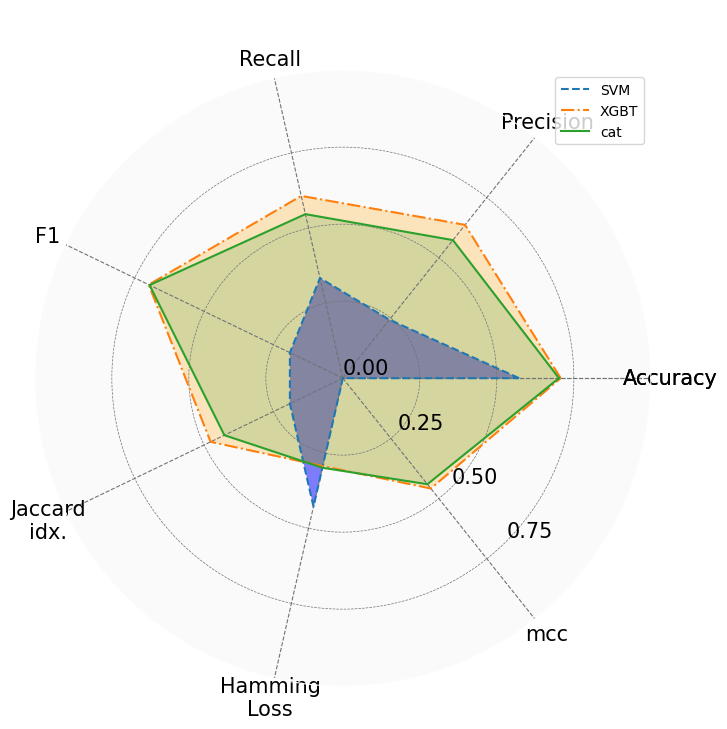

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

met = pd.read_csv('model/physiochemical/hemo_ref_models_3L.csv')
met = met[met.columns[1:]]

categories = ['Accuracy', 'Matthews\ncoef.','Precision', 'Recall', 'F1','Jaccard\nidx.','Hamming\nLoss']
categories = [*categories, categories[0]]

mdl_1 = met.iloc[0]
mdl_2 = met.iloc[1]
mdl_3 = met.iloc[2]

mdl_1 = [*mdl_1, mdl_1[0]]
mdl_2 = [*mdl_2, mdl_2[0]]
mdl_3 = [*mdl_3, mdl_3[0]]

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(mdl_1))

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(polar=True)
rad = (0,0.25,0.50,0.75)
ax.set_ylim(0,1)
ax.set_rgrids(rad,size = 20,angle= -45)
ax.xaxis.grid(True,color='k',linestyle='--',linewidth=0.5)



plt.plot(label_loc, mdl_2, 'orange',alpha=0.45,linestyle='--',marker=' ',label='XGBT')
plt.fill(label_loc, mdl_2, 'orange',alpha=0.75)

plt.plot(label_loc, mdl_3,'#77D970',alpha=0.45,linestyle='--',marker=' ',label='cat')
plt.fill(label_loc, mdl_3, '#77D970',alpha=0.75)

plt.plot(label_loc, mdl_1,'#9C19E0',linestyle='--',marker=' ',label='SVM')
plt.fill(label_loc, mdl_1, '#9C19E0',alpha=0.75)

plt.title(' ', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories, size= 20)
ax.spines['polar'].set_color('#FAFAFA')
ax.grid(which='major', axis='y', linestyle='--', color='k', linewidth=0.5) #ededed
ax.set_facecolor('#FAFAFA')
#plt.legend()
plt.savefig('model/physiochemical/fig/ref_radar_hemo_3L.tiff',dpi=600)

plt.show()

### roc

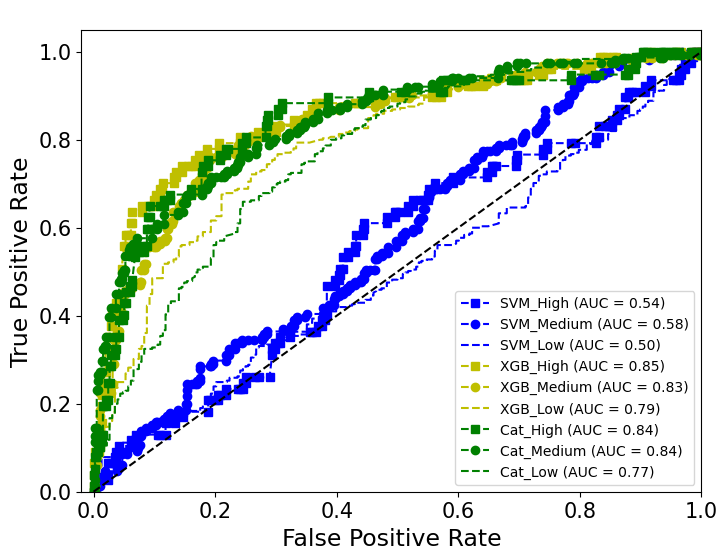

In [49]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import MultiLabelBinarizer

def multilab_roc(y_test,y_score,color,num_labels,label):

    ls = ['s--','o--','--']
    #Binarize labels
    lab = y_test.tolist()
    lab =[str(i) for i in lab]
    mlb = MultiLabelBinarizer()
    y_test_bin = mlb.fit_transform(lab)
    
    # Compute ROC & AUC
    fpr =dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_labels):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i],tpr[i])
    
    # plot the figure
    for i in range(num_labels):
        plt.plot(fpr[i], tpr[i],f'{color}{ls[i]}',label=label[i] + ' (AUC = %0.2f)' % roc_auc[i])
        #plt.legend(loc="lower right")

# probabilities
out_1_p = clf_5.predict_proba(X_test)
out_2_p = clf_1.predict_proba(X_test)
out_3_p = cat.predict_proba(X_test)

plt.figure(figsize=(8,6))
multilab_roc(y_test,out_1_p,'b',num_labels=3,label = ['SVM_High','SVM_Medium','SVM_Low'])
multilab_roc(y_test,out_2_p,'y',num_labels=3,label = ['XGB_High','XGB_Medium','XGB_Low'])
multilab_roc(y_test,out_3_p,'g',num_labels=3,label = ['Cat_High','Cat_Medium','Cat_Low'])
#multilab_roc(y_test,out_4_p,'r',num_labels=3,label = ['Tuned_High','Tuned_Medium','Tuned_Low'])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size = 17)
plt.ylabel('True Positive Rate', size = 17)
plt.xticks(size = 15),plt.yticks(size = 15)
plt.title(' ')
plt.legend(loc="lower right")
plt.savefig('model/physiochemical/fig/ref_models_hemo_roc_3L.tiff',dpi=600)
plt.show()

### confusion metrics

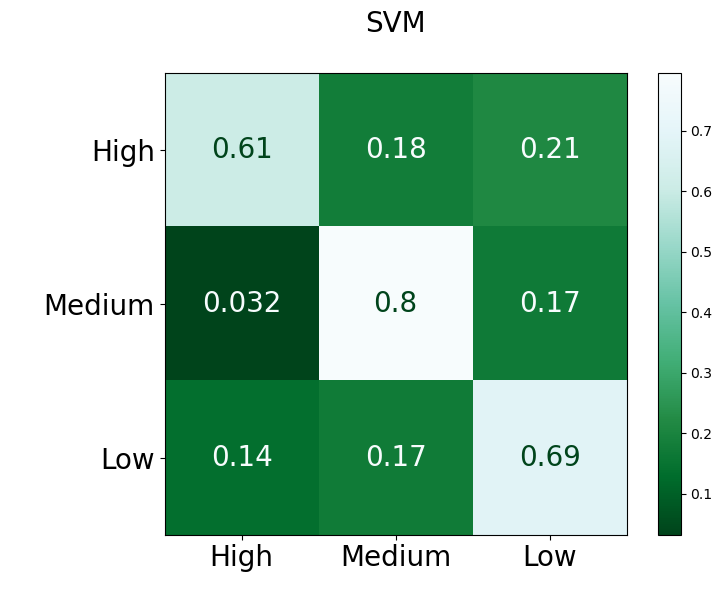

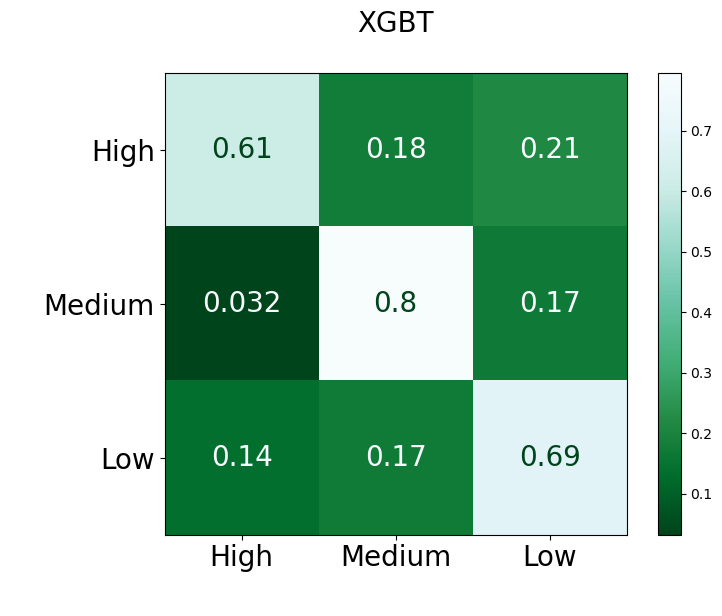

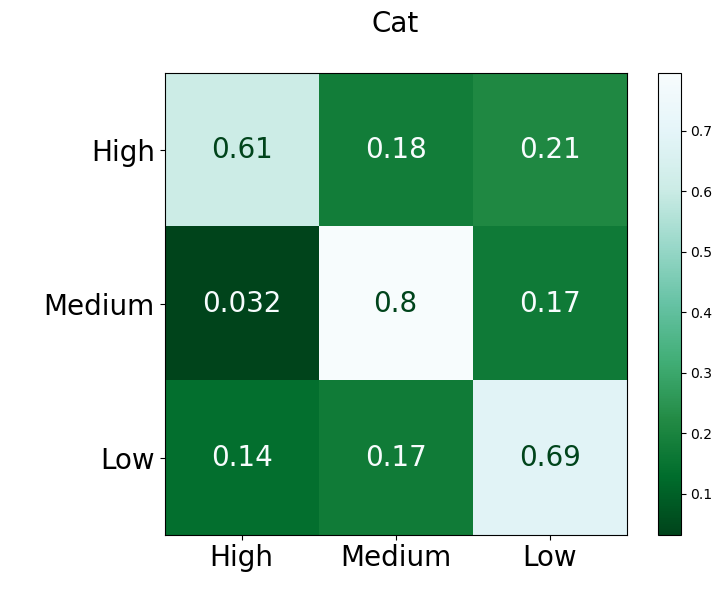

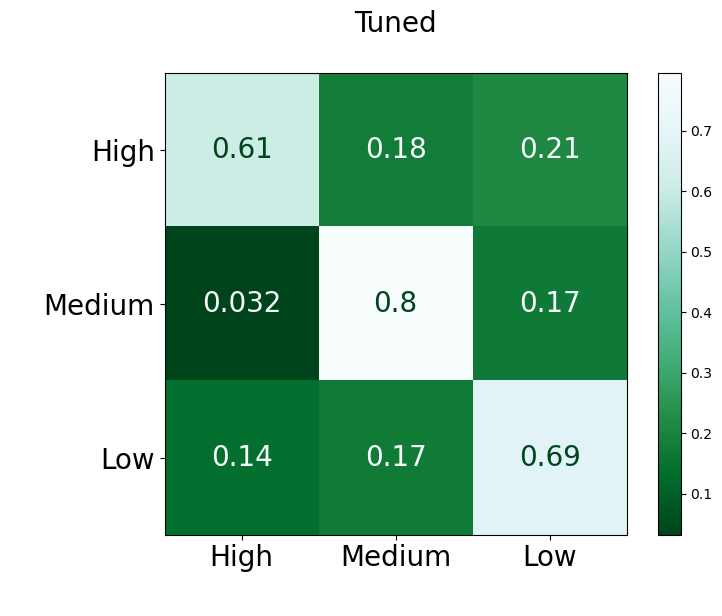

In [56]:
### 3L ###

from sklearn.metrics import ConfusionMatrixDisplay

# xgbt :: afmhot ; svm :: plasma ; cat :: BuGn_r

## svm
fig,ax = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay.from_predictions(y_pred_2,y_test,ax=ax,
                                        cmap = 'BuGn_r', normalize='true',
                                       text_kw={'size': 20})
ax.xaxis.set_ticklabels(['High','Medium','Low'],size=20,
                       rotation = 0)
ax.yaxis.set_ticklabels(['High','Medium','Low'],size=20,
                        rotation = 0)
ax.set_xlabel(' ',size=20)
ax.set_ylabel(' ',size=20)

plt.title('SVM\n',size = 20)
plt.savefig('model/physiochemical/fig/SVM_hemo_cm_3L.tiff',dpi = 600)


## xgbt
fig,ax = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay.from_predictions(y_pred_2,y_test,ax=ax,
                                        cmap = 'BuGn_r', normalize='true',
                                       text_kw={'size': 20})
ax.xaxis.set_ticklabels(['High','Medium','Low'],size=20,
                       rotation = 0)
ax.yaxis.set_ticklabels(['High','Medium','Low'],size=20,
                        rotation = 0)
ax.set_xlabel(' ',size=20)
ax.set_ylabel(' ',size=20)

plt.title('XGBT\n',size = 20)
plt.savefig('model/physiochemical/fig/XGBT_hemo_cm_3L.tiff',dpi = 600)


## Cat
fig,ax = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay.from_predictions(y_pred_2,y_test,ax=ax,
                                        cmap = 'BuGn_r', normalize='true',
                                       text_kw={'size': 20})
ax.xaxis.set_ticklabels(['High','Medium','Low'],size=20,
                       rotation = 0)
ax.yaxis.set_ticklabels(['High','Medium','Low'],size=20,
                        rotation = 0)
ax.set_xlabel(' ',size=20)
ax.set_ylabel(' ',size=20)

plt.title('Cat\n',size = 20)
plt.savefig('model/physiochemical/fig/cat_hemo_cm_3L.tiff',dpi = 600)


## Tuned
fig,ax = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay.from_predictions(y_pred_2,y_test,ax=ax,
                                        cmap = 'BuGn_r', normalize='true',
                                       text_kw={'size': 20})
ax.xaxis.set_ticklabels(['High','Medium','Low'],size=20,
                       rotation = 0)
ax.yaxis.set_ticklabels(['High','Medium','Low'],size=20,
                        rotation = 0)
ax.set_xlabel(' ',size=20)
ax.set_ylabel(' ',size=20)

plt.title('Tuned\n',size = 20)
plt.savefig('model/physiochemical/fig/Tuned_hemo_cm_3L.tiff',dpi = 600)

# protBERT+REF

In [1]:
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4080'

## Binary

### Data

In [58]:
data = pd.read_excel('mammals_hemolysis_compiled.xlsx', sheet_name = 'Sheet1')
data.head()

def process(txt):
  split = ' '.join(txt)
  return split

raw_data = pd.DataFrame()
encoder = preprocessing.LabelEncoder()
o = process(",".join(data['SEQUENCE']))
seq = o.split(',')

raw_data['real'] = data['SEQUENCE']
raw_data['processed'] = seq
raw_data['lab'] = encoder.fit_transform(data['bin_labels'])
raw_data.head()

,real,processed,lab
0,RVKRVWPLVIRTVIAGYNLYRAIKKK,R V K R V W P L V I R T V I A G Y N L Y R A I ...,0
1,GIWDTIKSMGKVFAGKILQNL,G I W D T I K S M G K V F A G K I L Q N L,1
2,DSHAKRHHGYKRKFHEKHHSHRGY,D S H A K R H H G Y K R K F H E K H H S H R G Y,1
3,GMASKAGAIAGKIAKVALKAL,G M A S K A G A I A G K I A K V A L K A L,1
4,ALWKTLLKKVLKAAA,A L W K T L L K K V L K A A A,0


In [62]:
X_train, X_test, y_train, y_test = train_test_split(raw_data.processed,raw_data.lab,
                                                    test_size =0.2,shuffle=True,random_state=42)
#test_size =0.1


### REF models

In [64]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import torch
import pickle
from transformers import AutoModel, AutoTokenizer

sequences = X_train
labels = y_train

torch.cuda.empty_cache()
tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert", seed = 42)
model = AutoModel.from_pretrained("Rostlab/prot_bert")
model.to('cuda:0')


# encoded data for traioning
with torch.no_grad():
    encoded_sequences = torch.stack([model(**tokenizer(s, return_tensors='pt').to('cuda:0'))[0][0][0] 
                                     for s in sequences]).cpu().detach().numpy()
# encoded data for testing
with torch.no_grad():
    test_sequences = torch.stack([model(**tokenizer(s, return_tensors='pt').to('cuda:0'))[0][0][0] 
                                  for s in X_test]).cpu().detach().numpy()

del model
torch.cuda.empty_cache()

#  Models #

## Support Vector Machine ##
clf_1 = SVC(probability=True)

## XGBoost classifier ##
clf_2 =XGBClassifier(max_depth=9)

## CatBoost classifier ##
clf_3 = CatBoostClassifier(iterations=300,
                           custom_loss=['Accuracy','Precision'],
                           early_stopping_rounds=20,task_type='GPU',
                           l2_leaf_reg=0.25,learning_rate=0.01,depth=10,
                           verbose=False,random_seed=42)



# Model fitting
clf_1.fit(encoded_sequences, labels)
clf_2.fit(encoded_sequences, labels)
clf_3.fit(encoded_sequences, labels)


# Saving models
pickle.dump(clf_1,open('model/NLP_tokenized/protBERT_hemo_bin_svc.pkl',"wb"))
pickle.dump(clf_2,open('model/NLP_tokenized/protBERT_hemo_bin_xgb.pkl',"wb"))
pickle.dump(clf_3,open('model/NLP_tokenized/protBERT_hemo_bin_cat.pkl',"wb"))


### tuned ProtBERT

#### Training

In [74]:
from transformers import BertModel, BertTokenizer, BertForSequenceClassification
import time

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
encoded_data = tokenizer.batch_encode_plus(X_train,return_attention_mask=True,padding=True,return_tensors='pt')
input_ids = encoded_data['input_ids'].to('cuda')
attention_masks = encoded_data['attention_mask'].to('cuda')
labels= torch.tensor(y_train, dtype=torch.long).to('cuda')

model = BertForSequenceClassification.from_pretrained("Rostlab/prot_bert",num_labels=2,output_attentions=False)
model.to('cuda')
batch_size =100
epochs =20
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-5)

acc=[]
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    for i in range(0, input_ids.size(0),batch_size):
        optimizer.zero_grad()
        outputs = model(input_ids[i:i+batch_size],attention_mask=attention_masks[i:i+batch_size],labels=labels[i:i+batch_size])
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        #torch.cuda.empty_cache()
    epoch_time = time.time() - start_time
    eta = epoch_time * (epochs - epoch - 1)
    with torch.no_grad():
        outputs =  model(input_ids,attention_mask=attention_masks)
        predictions = torch.argmax(outputs[0],dim=1).flatten()
        accuracy =torch.sum(predictions == labels)/len(labels)
        acc.append(accuracy.int())
       
   
    print(f'Epoch [{epoch+1}/{epochs}], ETA: {eta:.2f}s, Accuracy: {accuracy:.2f}')

f = 'model/aasp_hemo_tuned_protbert_bin_EPC20.pth'
torch.save(model.state_dict(),f)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Rostlab/prot_bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/20], ETA: 9110.92s, Accuracy: 0.69
Epoch [2/20], ETA: 8898.95s, Accuracy: 0.76
Epoch [3/20], ETA: 8402.20s, Accuracy: 0.77
Epoch [4/20], ETA: 8085.73s, Accuracy: 0.82
Epoch [5/20], ETA: 7507.93s, Accuracy: 0.87
Epoch [6/20], ETA: 7557.37s, Accuracy: 0.87
Epoch [7/20], ETA: 6988.08s, Accuracy: 0.89
Epoch [8/20], ETA: 6269.34s, Accuracy: 0.90
Epoch [9/20], ETA: 5940.59s, Accuracy: 0.91
Epoch [10/20], ETA: 5439.33s, Accuracy: 0.91
Epoch [11/20], ETA: 4614.55s, Accuracy: 0.93
Epoch [12/20], ETA: 4026.58s, Accuracy: 0.93
Epoch [13/20], ETA: 3547.01s, Accuracy: 0.95
Epoch [14/20], ETA: 3071.64s, Accuracy: 0.94
Epoch [15/20], ETA: 2499.28s, Accuracy: 0.96
Epoch [16/20], ETA: 2040.12s, Accuracy: 0.95
Epoch [17/20], ETA: 1499.05s, Accuracy: 0.96
Epoch [18/20], ETA: 1002.11s, Accuracy: 0.96
Epoch [19/20], ETA: 498.60s, Accuracy: 0.96
Epoch [20/20], ETA: 0.00s, Accuracy: 0.96


#### Testing

In [114]:
from transformers import BertTokenizer, BertForSequenceClassification
import torcheval.metrics.functional as F

model = BertForSequenceClassification.from_pretrained("Rostlab/prot_bert",num_labels=2,output_attentions=False)
model_state_dict = torch.load('model/aasp_hemo_tuned_protbert_bin_EPC20.pth')
model.load_state_dict(model_state_dict, strict=False)
labels= torch.tensor(y_test.values,dtype=torch.int64)

model.eval()
torch.manual_seed(42)
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False, seed = 42)
encoded_data = tokenizer.batch_encode_plus(X_test,return_attention_mask=True,padding=True,return_tensors='pt')
input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']

with torch.no_grad():
        outputs =  model(input_ids,attention_mask=attention_masks)
        predictions = torch.argmax(outputs[0],dim=1).flatten()

out_4 = predictions.numpy()
#acc = F.multiclass_accuracy(predictions,labels,num_classes=3,average='macro')
#acc_2 = F.binary_accuracy(predictions,labels)
#prs = F.multiclass_precision(predictions,labels,num_classes=3,average='macro')
#class_names = ["High", "Medium", "Low"] 
#final_labels = [class_names[i] for i in predictions]
#print(predictions)
#print(acc_2)
#print(prs)

import torch.nn.functional as F
logits = outputs.logits
probabilities = F.softmax(logits, dim=-1)
out_4_p = 1-probabilities[:,0]
print('probabilities calculated')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Rostlab/prot_bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mdlab_2\AppData\Local\Temp\ipykernel_10356\1766439755.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serial

probabilities calculated


### metrics

In [116]:
from sklearn import metrics


# Testing
out_1 = clf_1.predict(test_sequences)
out_2 = clf_2.predict(test_sequences)
out_3 = clf_3.predict(test_sequences)

# probabilities
out_1_p = clf_1.predict_proba(test_sequences)[:, 1]
out_2_p = clf_2.predict_proba(test_sequences)[:, 1]
out_3_p = clf_3.predict_proba(test_sequences)[:, 1]


acc_1 = metrics.accuracy_score(out_1,y_test)
acc_2 = metrics.accuracy_score(out_2,y_test)
acc_3 = metrics.accuracy_score(out_3,y_test)
acc_4 = metrics.accuracy_score(out_4,y_test)

mcc_1 = metrics.matthews_corrcoef(out_1,y_test)
mcc_2 = metrics.matthews_corrcoef(out_2,y_test)
mcc_3 = metrics.matthews_corrcoef(out_3,y_test)
mcc_4 = metrics.matthews_corrcoef(out_4,y_test)

prs_1 = metrics.precision_score(out_1,y_test,average='macro')
prs_2 = metrics.precision_score(out_2,y_test,average='macro')
prs_3 = metrics.precision_score(out_3,y_test,average='macro')
prs_4 = metrics.precision_score(out_4, y_test,average='macro')

rcl_1 = metrics.recall_score(out_1,y_test,average='macro')
rcl_2 = metrics.recall_score(out_2,y_test,average='macro')
rcl_3 = metrics.recall_score(out_3,y_test,average='macro')
rcl_4 = metrics.recall_score(out_4, y_test,average='macro')

F1_1 = metrics.f1_score(out_1,y_test,average='macro')
F1_2 = metrics.f1_score(out_2,y_test,average='macro')
F1_3 = metrics.f1_score(out_3,y_test,average='macro')
F1_4 = metrics.f1_score(out_4, y_test,average='macro')

jac_1 = metrics.jaccard_score(out_1,y_test,average='macro')
jac_2 = metrics.jaccard_score(out_2,y_test,average='macro')
jac_3 = metrics.jaccard_score(out_3,y_test,average='macro')
jac_4 = metrics.jaccard_score(out_4, y_test,average='macro')

loss_1 = metrics.hamming_loss(out_1,y_test)
loss_2 = metrics.hamming_loss(out_2,y_test)
loss_3 = metrics.hamming_loss(out_3,y_test)
loss_4 = metrics.hamming_loss(out_4,y_test)

model_metrics = pd.DataFrame()
model_metrics ['model']=['SVM','XGBT','Cat','Tuned']
model_metrics ['acc']=[acc_1, acc_2, acc_3,acc_4]
model_metrics ['mcc']=[mcc_1, mcc_2, mcc_3,mcc_4]
model_metrics ['prs']=[prs_1, prs_2, prs_3,prs_4]
model_metrics ['rcl']=[rcl_1, rcl_2, rcl_3,rcl_4]
model_metrics['F1']=[F1_1, F1_2, F1_3,F1_4]
model_metrics['jac']=[jac_1, jac_2, jac_3,jac_4]
model_metrics['loss']=[loss_1, loss_2, loss_3,loss_4]


model_metrics.to_csv('model/NLP_tokenized/protBERT_ref_metrics_hemo_bin.csv')
model_metrics.head()

,model,acc,mcc,prs,rcl,F1,jac,loss
0,SVM,0.613508,0.231857,0.615427,0.616432,0.613115,0.442195,0.386492
1,XGBT,0.722326,0.444742,0.722509,0.722233,0.722208,0.565232,0.277674
2,Cat,0.694184,0.388068,0.694130,0.693938,0.693973,0.531420,0.305816
3,Tuned,0.754221,0.520672,0.757324,0.763384,0.753332,0.604503,0.245779


### radar

C:\Users\mdlab_2\AppData\Local\Temp\ipykernel_10356\3433820271.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mdl_1 = [*mdl_1, mdl_1[0]]
C:\Users\mdlab_2\AppData\Local\Temp\ipykernel_10356\3433820271.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mdl_2 = [*mdl_2, mdl_2[0]]
C:\Users\mdlab_2\AppData\Local\Temp\ipykernel_10356\3433820271.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mdl_3 = [*mdl_3, mdl_3[0]]
C:\User

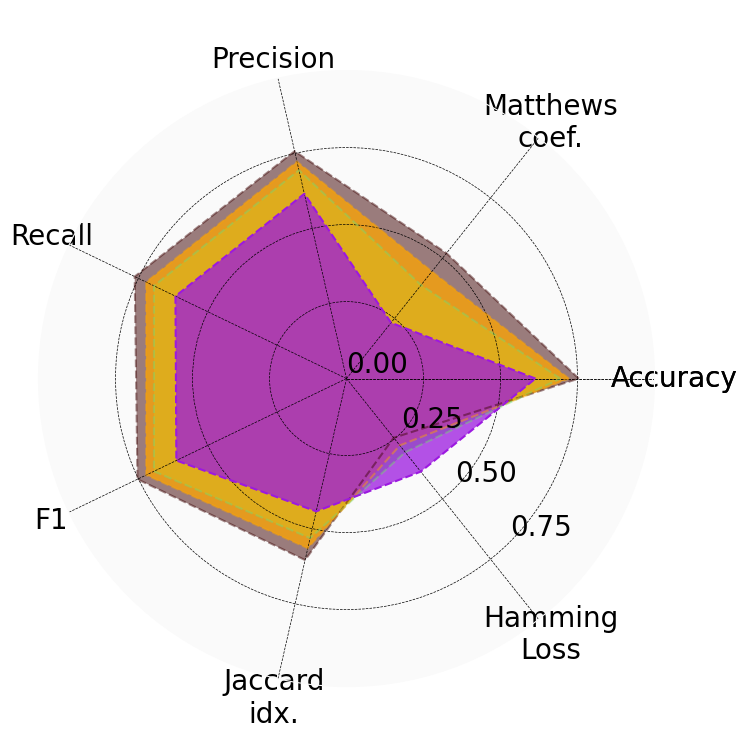

In [118]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

met = pd.read_csv('model/NLP_tokenized/protBERT_ref_metrics_hemo_bin.csv')
met.pop('model')
met = met[met.columns[1:]]

categories = ['Accuracy', 'Matthews\ncoef.','Precision', 'Recall', 'F1','Jaccard\nidx.','Hamming\nLoss']
categories = [*categories, categories[0]]

mdl_1 = met.iloc[0]
mdl_2 = met.iloc[1]
mdl_3 = met.iloc[2]
mdl_4 = met.iloc[3]

mdl_1 = [*mdl_1, mdl_1[0]]
mdl_2 = [*mdl_2, mdl_2[0]]
mdl_3 = [*mdl_3, mdl_3[0]]
mdl_4 = [*mdl_4, mdl_4[0]]

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(mdl_1))

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(polar=True)
rad = (0,0.25,0.50,0.75)
ax.set_ylim(0,1)
ax.set_rgrids(rad,size = 20,angle= -45)
ax.xaxis.grid(True,color='k',linestyle='--',linewidth=0.5)



plt.plot(label_loc, mdl_4,'#3B0000',alpha=0.45,linestyle='--',marker=' ',label='Tuned')
plt.fill(label_loc, mdl_4, '#3B0000',alpha=0.5)                                               #hatch=r"//"

plt.plot(label_loc, mdl_3,'#77D970',alpha=0.45,linestyle='--',marker=' ',label='cat')
plt.fill(label_loc, mdl_3, '#77D970',alpha=0.75)

plt.plot(label_loc, mdl_2, 'orange',alpha=0.45,linestyle='--',marker=' ',label='XGBT')
plt.fill(label_loc, mdl_2, 'orange',alpha=0.75)

plt.plot(label_loc, mdl_1,'#9C19E0',linestyle='--',marker=' ',label='SVM')
plt.fill(label_loc, mdl_1, '#9C19E0',alpha=0.75)

plt.title(' ', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories, size= 20)
ax.spines['polar'].set_color('#FAFAFA')
ax.grid(which='major', axis='y', linestyle='--', color='k', linewidth=0.5) #ededed
ax.set_facecolor('#FAFAFA')
#plt.legend()
plt.savefig('model/NLP_tokenized/fig/NLP_models_hemo_bin_tiff',dpi=600)

plt.show()

### roc

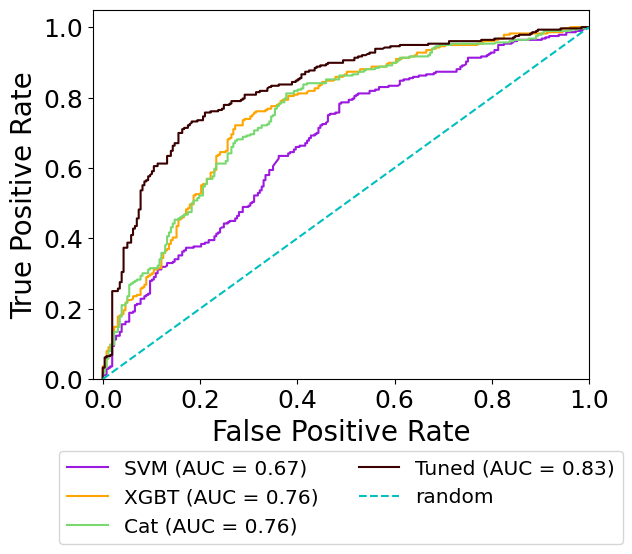

In [120]:
from sklearn.metrics import roc_curve, auc

fpr_1, tpr_1, thresholds = roc_curve(y_test, out_1_p) 
auc_1 = auc(fpr_1, tpr_1)

fpr_2, tpr_2, thresholds = roc_curve(y_test, out_2_p) 
auc_2 = auc(fpr_2, tpr_2)

fpr_3, tpr_3, thresholds = roc_curve(y_test, out_3_p) 
auc_3 = auc(fpr_3, tpr_3)

fpr_4, tpr_4, thresholds = roc_curve(y_test, out_4_p) 
auc_4 = auc(fpr_4, tpr_4)

# Plot the ROC curve
plt.figure()  
plt.plot(fpr_1, tpr_1,'#9C19E0', label='SVM (AUC = %0.2f)' % auc_1)
plt.plot(fpr_2, tpr_2,'orange', label='XGBT (AUC = %0.2f)' % auc_2)
plt.plot(fpr_3, tpr_3,'#77D970', label='Cat (AUC = %0.2f)' % auc_3)
plt.plot(fpr_4, tpr_4,'#3B0000', label='Tuned (AUC = %0.2f)' % auc_4)


plt.plot([0, 1], [0, 1], 'c--', label='random')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',size=20)
plt.ylabel('True Positive Rate',size=20)
plt.xticks(size=18), plt.yticks(size=18)
plt.legend(bbox_to_anchor=(0.5, -0.32),loc="center",ncol=2,prop={'size': 14.5})
plt.savefig('model/NLP_tokenized/fig/hemo_model_roc_bin.png',dpi=600,bbox_inches='tight')

plt.show()

### confusion matrix

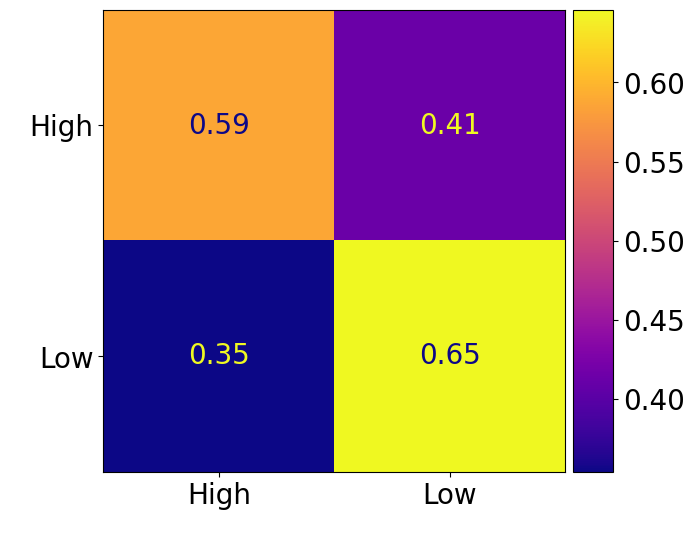

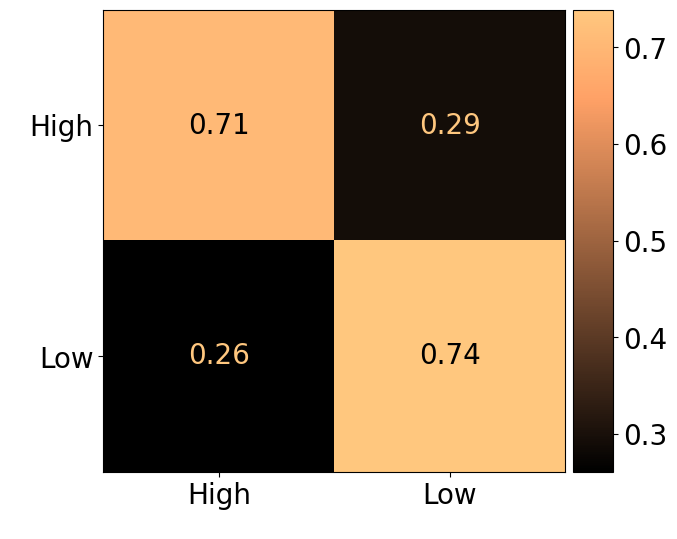

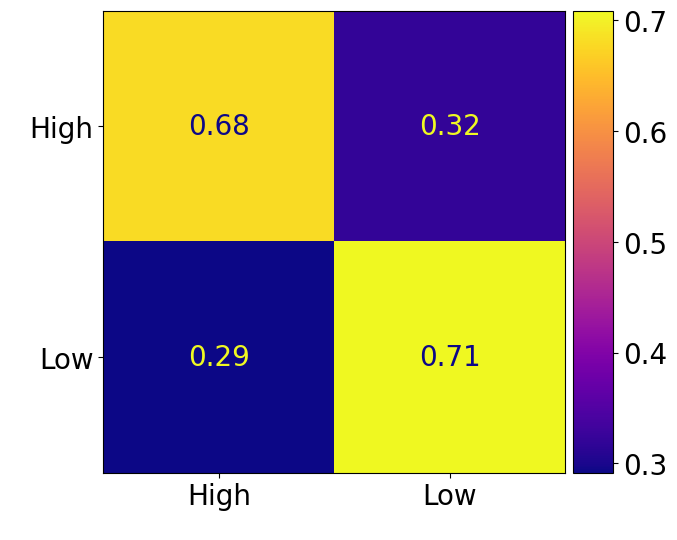

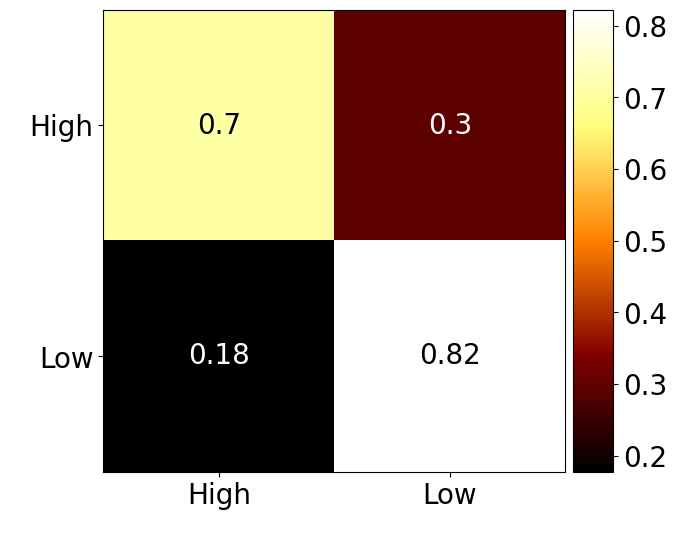

In [122]:
from sklearn.metrics import ConfusionMatrixDisplay

# SVM
fig,ax = plt.subplots(figsize=(8,6))
cmp = ConfusionMatrixDisplay.from_predictions(out_1,y_test,ax=ax,cmap = 'plasma',colorbar=False, 
                                        normalize='true',text_kw={'size': 20})
plt.tick_params(axis='both', which='major', labelsize=20)
ax.xaxis.set_ticklabels(['High','Low'])
ax.yaxis.set_ticklabels(['High','Low'])
plt.xlabel(' '), plt.ylabel(' ')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.05,ax.get_position().height])
plt.colorbar(cmp.im_,  cax=cax)
plt.tick_params(axis='y', labelsize=20)
plt.savefig('model/NLP_tokenized/fig/SVM_hemo_cm_bin.png',dpi=600)

# XGBT
fig,ax = plt.subplots(figsize=(8,6))
cmp = ConfusionMatrixDisplay.from_predictions(out_2,y_test,ax=ax,cmap = 'copper',colorbar=False,
                                        normalize='true',text_kw={'size': 20})
plt.tick_params(axis='both', which='major', labelsize=20)
ax.xaxis.set_ticklabels(['High','Low'])
ax.yaxis.set_ticklabels(['High','Low'])
plt.xlabel(' '), plt.ylabel(' ')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.05,ax.get_position().height])
plt.colorbar(cmp.im_,  cax=cax)
plt.tick_params(axis='y', labelsize=20)
plt.savefig('model/NLP_tokenized/fig/XGB_hemo_cm_bin.png',dpi=600)

# Cat
fig,ax = plt.subplots(figsize=(8,6))
cmp = ConfusionMatrixDisplay.from_predictions(out_3,y_test,ax=ax,cmap = 'plasma',colorbar=False, 
                                        normalize='true',text_kw={'size': 20})
plt.tick_params(axis='both', which='major', labelsize=20)
ax.xaxis.set_ticklabels(['High','Low'])
ax.yaxis.set_ticklabels(['High','Low'])
plt.xlabel(' '), plt.ylabel(' ')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.05,ax.get_position().height])
plt.colorbar(cmp.im_,  cax=cax)
plt.tick_params(axis='y', labelsize=20)
plt.savefig('model/NLP_tokenized/fig/cat_hemo_cm_bin.png',dpi=600)

#Tuned
fig,ax = plt.subplots(figsize=(8,6))
cmp = ConfusionMatrixDisplay.from_predictions(out_4,y_test,ax=ax,cmap = 'afmhot',colorbar=False, 
                                        normalize='true',text_kw={'size': 20})
plt.tick_params(axis='both', which='major', labelsize=20)
ax.xaxis.set_ticklabels(['High','Low'])
ax.yaxis.set_ticklabels(['High','Low'])
plt.xlabel(' '), plt.ylabel(' ')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.05,ax.get_position().height])
plt.colorbar(cmp.im_,  cax=cax)
plt.tick_params(axis='y', labelsize=20)
plt.savefig('model/NLP_tokenized/fig/Tuned_hemo_protbert_cm_bin.png',dpi=600)


### rnn clf

In [72]:
data = pd.read_excel('sorted_seq_bin.xlsx', sheet_name = 'final')
data.head()

def process(txt):
  split = ' '.join(txt)
  return split

raw_data = pd.DataFrame()
encoder = preprocessing.LabelEncoder()
o = process(",".join(data['Sequence']))
seq = o.split(',')

raw_data['processed'] = seq
raw_data['lab'] = encoder.fit_transform(data['lab'])
raw_data.head()

,processed,lab
0,G I G S A L A K A A K L V A G I V,2
1,G I G S A L A K A A K L V A G I V,2
2,A A F R G C W T K N Y S P K P C L,2
3,F L P L V L G A L S G I L P K I L,0
4,F F P L L F G A L S S H L P K L F,0


In [74]:
X_train, X_test, y_train, y_test = train_test_split(raw_data.processed,raw_data.lab,test_size=0.1)

In [82]:
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelBinarizer
from torch.utils.data import DataLoader
import gc
tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert")
model = AutoModel.from_pretrained("Rostlab/prot_bert")
model.to('cuda:0')



# encoded data for traioning
with torch.no_grad():
    encoded_sequences = torch.stack([model(**tokenizer(s, return_tensors='pt').to('cuda:0'))[0][0][0] 
                                     for s in X_train.values])

with torch.no_grad():
    test_sequences = torch.stack([model(**tokenizer(s, return_tensors='pt').to('cuda:0'))[0][0][0] 
                                     for s in X_test.values])

lb = LabelBinarizer()
y_bin = lb.fit_transform(y_train.tolist())
labels = torch.tensor(y_bin).to('cuda:0')

loader = DataLoader(list(zip(encoded_sequences, labels)), shuffle=True, batch_size=16)
del model
torch.cuda.empty_cache()

In [86]:
# Architechture
class RNN(nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        torch.cuda.manual_seed_all(42)
        #self.Norm1 = nn.Linear(5000, 2070)
        self.lstm = torch.nn.LSTM(input_size=encoded_sequences.shape[-1], hidden_size=3,
                                  bidirectional = False,
                                  num_layers = 10,
                                  batch_first=True)
    def forward(self,x):
        #x = self.Norm1(x)
        x,_ = self.lstm(x)
        return x
        
# Train the model
model = RNN()
model.to('cuda:0')
n_epochs = 500
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
model.train()
for epoch in range(n_epochs):
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #gc.collect()
        torch.cuda.empty_cache()

In [84]:
from torchmetrics import Accuracy, Precision
model.eval()
y_pred = model(torch.tensor(test_sequences).to('cuda:0'))

y_test_bin = lb.fit_transform(y_test.tolist())

Accuracy = Accuracy(task="Binary").to('cuda:0')
Precision = Precision(task="Binary").to('cuda:0')

accuracy_score = Accuracy(y_pred, torch.tensor(y_test_bin).to('cuda:0'))
precision_score = Precision(y_pred, torch.tensor(y_test_bin).to('cuda:0'))

print(accuracy_score,precision_score)

NameError: name 'model' is not defined

### ESM

## Multi_label

### Data

In [66]:
data = pd.read_excel('mammals_hemolysis_compiled.xlsx', sheet_name = 'Sheet1')
data.head()

def process(txt):
  split = ' '.join(txt)
  return split

raw_data = pd.DataFrame()
encoder = preprocessing.LabelEncoder()
o = process(",".join(data['SEQUENCE']))
seq = o.split(',')

raw_data['real'] = data['SEQUENCE']
raw_data['processed'] = seq
raw_data['lab'] = encoder.fit_transform(data['multi_labels'])
raw_data.head()

,real,processed,lab
0,RVKRVWPLVIRTVIAGYNLYRAIKKK,R V K R V W P L V I R T V I A G Y N L Y R A I ...,2
1,GIWDTIKSMGKVFAGKILQNL,G I W D T I K S M G K V F A G K I L Q N L,2
2,DSHAKRHHGYKRKFHEKHHSHRGY,D S H A K R H H G Y K R K F H E K H H S H R G Y,2
3,GMASKAGAIAGKIAKVALKAL,G M A S K A G A I A G K I A K V A L K A L,2
4,ALWKTLLKKVLKAAA,A L W K T L L K K V L K A A A,2


In [68]:
X_train, X_test, y_train, y_test = train_test_split(raw_data.processed,raw_data.lab,
                                                    test_size =0.2,shuffle=True,random_state=42)
#test_size =0.1

### REF models

In [70]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import torch
import pickle
from transformers import AutoModel, AutoTokenizer

sequences = X_train
labels = y_train

torch.cuda.empty_cache()
tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert", seed = 42)
model = AutoModel.from_pretrained("Rostlab/prot_bert")
model.to('cuda:0')


# encoded data for traioning
with torch.no_grad():
    encoded_sequences = torch.stack([model(**tokenizer(s, return_tensors='pt').to('cuda:0'))[0][0][0] 
                                     for s in sequences]).cpu().detach().numpy()
# encoded data for testing
with torch.no_grad():
    test_sequences = torch.stack([model(**tokenizer(s, return_tensors='pt').to('cuda:0'))[0][0][0] 
                                  for s in X_test]).cpu().detach().numpy()

del model
torch.cuda.empty_cache()

#  Models #

## Support Vector Machine ##
clf_1 = SVC(probability=True)

## XGBoost classifier ##
clf_2 =XGBClassifier(max_depth=9)

## CatBoost classifier ##
clf_3 = CatBoostClassifier(iterations=300,
                           custom_loss=['Accuracy','Precision'],
                           early_stopping_rounds=20,task_type='GPU',
                           l2_leaf_reg=0.25,learning_rate=0.01,depth=10,
                           verbose=False,random_seed=42)



# Model fitting
clf_1.fit(encoded_sequences, labels)
clf_2.fit(encoded_sequences, labels)
clf_3.fit(encoded_sequences, labels)


# Saving models
pickle.dump(clf_1,open('model/NLP_tokenized/protBERT_hemo_3L_svc.pkl',"wb"))
pickle.dump(clf_2,open('model/NLP_tokenized/protBERT_hemo_3L_xgb.pkl',"wb"))
pickle.dump(clf_3,open('model/NLP_tokenized/protBERT_hemo_3L_cat.pkl',"wb"))


Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0


### Tuned Protbert

#### Training

In [9]:
from transformers import BertModel, BertTokenizer, BertForSequenceClassification
import time

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
encoded_data = tokenizer.batch_encode_plus(X_train,return_attention_mask=True,padding=True,return_tensors='pt')
input_ids = encoded_data['input_ids'].to('cuda')
attention_masks = encoded_data['attention_mask'].to('cuda')
labels= torch.tensor(y_train, dtype=torch.long).to('cuda')

model = BertForSequenceClassification.from_pretrained("Rostlab/prot_bert",num_labels=3,output_attentions=False)
model.to('cuda')
batch_size =100
epochs =20
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-5)

acc=[]
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    for i in range(0, input_ids.size(0),batch_size):
        optimizer.zero_grad()
        outputs = model(input_ids[i:i+batch_size],attention_mask=attention_masks[i:i+batch_size],labels=labels[i:i+batch_size])
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        #torch.cuda.empty_cache()
    epoch_time = time.time() - start_time
    eta = epoch_time * (epochs - epoch - 1)
    with torch.no_grad():
        outputs =  model(input_ids,attention_mask=attention_masks)
        predictions = torch.argmax(outputs[0],dim=1).flatten()
        accuracy =torch.sum(predictions == labels)/len(labels)
        acc.append(accuracy.int())
       
   
    print(f'Epoch [{epoch+1}/{epochs}], ETA: {eta:.2f}s, Accuracy: {accuracy:.2f}')

f = 'model/aasp_hemo_tuned_protbert_3L_EPC20.pth'
torch.save(model.state_dict(),f)

C:\Users\mdlab_2\anaconda3\envs\torch_LSTM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Rostlab/prot_bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/20], ETA: 16142.33s, Accuracy: 0.58
Epoch [2/20], ETA: 15523.49s, Accuracy: 0.58
Epoch [3/20], ETA: 14656.55s, Accuracy: 0.58
Epoch [4/20], ETA: 13795.91s, Accuracy: 0.58
Epoch [5/20], ETA: 12931.32s, Accuracy: 0.61
Epoch [6/20], ETA: 12070.34s, Accuracy: 0.61
Epoch [7/20], ETA: 11207.77s, Accuracy: 0.67
Epoch [8/20], ETA: 10344.86s, Accuracy: 0.70
Epoch [9/20], ETA: 9486.05s, Accuracy: 0.70
Epoch [10/20], ETA: 8619.16s, Accuracy: 0.75
Epoch [11/20], ETA: 7759.08s, Accuracy: 0.82
Epoch [12/20], ETA: 6897.59s, Accuracy: 0.86
Epoch [13/20], ETA: 6034.95s, Accuracy: 0.87
Epoch [14/20], ETA: 5173.38s, Accuracy: 0.87
Epoch [15/20], ETA: 4309.27s, Accuracy: 0.85
Epoch [16/20], ETA: 3448.17s, Accuracy: 0.87
Epoch [17/20], ETA: 2585.56s, Accuracy: 0.91
Epoch [18/20], ETA: 1723.39s, Accuracy: 0.91
Epoch [19/20], ETA: 862.00s, Accuracy: 0.93
Epoch [20/20], ETA: 0.00s, Accuracy: 0.90


#### testing

In [72]:
from transformers import BertTokenizer, BertForSequenceClassification
import torcheval.metrics.functional as F

model = BertForSequenceClassification.from_pretrained("Rostlab/prot_bert",num_labels=3,output_attentions=False)
model_state_dict = torch.load('model/aasp_hemo_tuned_protbert_3L_EPC20.pth')
model.load_state_dict(model_state_dict, strict=False)
labels= torch.tensor(y_test.values,dtype=torch.int64)

model.eval()
torch.manual_seed(42)
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False, seed = 42)
encoded_data = tokenizer.batch_encode_plus(X_test,return_attention_mask=True,padding=True,return_tensors='pt')
input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']

with torch.no_grad():
        outputs =  model(input_ids,attention_mask=attention_masks)
        predictions = torch.argmax(outputs[0],dim=1).flatten()

out_4 = predictions.numpy()
#acc = F.multiclass_accuracy(predictions,labels,num_classes=3,average='macro')
#acc_2 = F.binary_accuracy(predictions,labels)
#prs = F.multiclass_precision(predictions,labels,num_classes=3,average='macro')
#class_names = ["High", "Medium", "Low"] 
#final_labels = [class_names[i] for i in predictions]
#print(predictions)
#print(acc_2)
#print(prs)

import torch.nn.functional as F
logits = outputs.logits
probabilities = F.softmax(logits, dim=-1)
out_4_p = probabilities
print('probabilities calculated')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Rostlab/prot_bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mdlab_2\AppData\Local\Temp\ipykernel_29020\564907280.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seriali

probabilities calculated


### metrics

In [74]:
from sklearn import metrics


# Testing
out_1 = clf_1.predict(test_sequences)
out_2 = clf_2.predict(test_sequences)
out_3 = clf_3.predict(test_sequences)

# probabilities
out_1_p = clf_1.predict_proba(test_sequences)
out_2_p = clf_2.predict_proba(test_sequences)
out_3_p = clf_3.predict_proba(test_sequences)

acc_1 = metrics.accuracy_score(out_1,y_test)
acc_2 = metrics.accuracy_score(out_2,y_test)
acc_3 = metrics.accuracy_score(out_3,y_test)
acc_4 = metrics.accuracy_score(out_4,y_test)

mcc_1 = metrics.matthews_corrcoef(out_1,y_test)
mcc_2 = metrics.matthews_corrcoef(out_2,y_test)
mcc_3 = metrics.matthews_corrcoef(out_3,y_test)
mcc_4 = metrics.matthews_corrcoef(out_4,y_test)

prs_1 = metrics.precision_score(out_1,y_test,average='macro')
prs_2 = metrics.precision_score(out_2,y_test,average='macro')
prs_3 = metrics.precision_score(out_3,y_test,average='macro')
prs_4 = metrics.precision_score(out_4, y_test,average='macro')


rcl_1 = metrics.recall_score(out_1,y_test,average='macro')
rcl_2 = metrics.recall_score(out_2,y_test,average='macro')
rcl_3 = metrics.recall_score(out_3,y_test,average='macro')
rcl_4 = metrics.recall_score(out_4, y_test,average='macro')

F1_1 = metrics.f1_score(out_1,y_test,average='macro')
F1_2 = metrics.f1_score(out_2,y_test,average='macro')
F1_3 = metrics.f1_score(out_3,y_test,average='macro')
F1_4 = metrics.f1_score(out_4, y_test,average='macro')


jac_1 = metrics.jaccard_score(out_1,y_test,average='macro')
jac_2 = metrics.jaccard_score(out_2,y_test,average='macro')
jac_3 = metrics.jaccard_score(out_3,y_test,average='macro')
jac_4 = metrics.jaccard_score(out_4, y_test,average='macro')

loss_1 = metrics.hamming_loss(out_1,y_test)
loss_2 = metrics.hamming_loss(out_2,y_test)
loss_3 = metrics.hamming_loss(out_3,y_test)
loss_4 = metrics.hamming_loss(out_4, y_test)

model_metrics = pd.DataFrame()
model_metrics ['model']=['SVM','XGBT','Cat','Tuned']
model_metrics ['acc']=[acc_1, acc_2, acc_3, acc_4]
model_metrics ['mcc']=[mcc_1, mcc_2, mcc_3, mcc_4]
model_metrics ['prs']=[prs_1, prs_2, prs_3, prs_4]
model_metrics ['rcl']=[rcl_1, rcl_2, rcl_3, rcl_4]
model_metrics['F1']=[F1_1, F1_2, F1_3, F1_4]
model_metrics['jac']=[jac_1, jac_2, jac_3, jac_4]
model_metrics['loss']=[loss_1, loss_2, loss_3,loss_4]


model_metrics.to_csv('protBERT_ref_metrics_hemo_3L.csv')
model_metrics.head()

C:\Users\mdlab_2\anaconda3\envs\torch_LSTM\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mdlab_2\anaconda3\envs\torch_LSTM\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,model,acc,mcc,prs,rcl,F1,jac,loss
0,SVM,0.724258,0.000000,0.333333,0.241419,0.280027,0.241419,0.275742
1,XGBT,0.781850,0.401986,0.557723,0.823057,0.624409,0.477510,0.218150
2,Cat,0.781850,0.382803,0.423164,0.517898,0.433447,0.346821,0.218150
3,Tuned,0.781850,0.566460,0.863221,0.565103,0.571266,0.465726,0.218150


### radar

C:\Users\mdlab_2\AppData\Local\Temp\ipykernel_29020\2427880478.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mdl_1 = [*mdl_1, mdl_1[0]]
C:\Users\mdlab_2\AppData\Local\Temp\ipykernel_29020\2427880478.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mdl_2 = [*mdl_2, mdl_2[0]]
C:\Users\mdlab_2\AppData\Local\Temp\ipykernel_29020\2427880478.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mdl_3 = [*mdl_3, mdl_3[0]]
C:\User

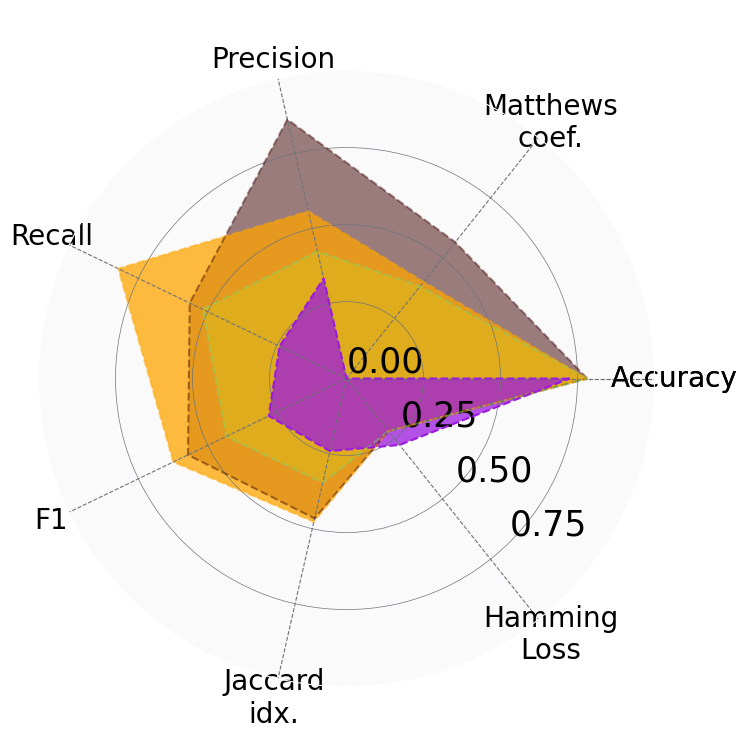

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

met = pd.read_csv('protBERT_ref_metrics_hemo_3L.csv')
met.pop('model')
met = met[met.columns[1:]]

categories = ['Accuracy', 'Matthews\ncoef.','Precision', 'Recall', 'F1','Jaccard\nidx.','Hamming\nLoss']
categories = [*categories, categories[0]]

mdl_1 = met.iloc[0]
mdl_2 = met.iloc[1]
mdl_3 = met.iloc[2]
mdl_4 = met.iloc[3]

mdl_1 = [*mdl_1, mdl_1[0]]
mdl_2 = [*mdl_2, mdl_2[0]]
mdl_3 = [*mdl_3, mdl_3[0]]
mdl_4 = [*mdl_4, mdl_4[0]]

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(mdl_1))

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(polar=True)
rad = (0,0.25,0.50,0.75)
ax.set_ylim(0,1)
ax.set_rgrids(rad,size = 25,angle= -45)
ax.xaxis.grid(True,color='#6F7378',linestyle='--')


plt.plot(label_loc, mdl_4,'#3B0000',alpha=0.45,linestyle='--',marker=' ',label='Tuned')
plt.fill(label_loc, mdl_4, '#3B0000',alpha=0.5)                                               #hatch=r"//"

plt.plot(label_loc, mdl_3,'#77D970',alpha=0.45,linestyle='--',marker=' ',label='cat')
plt.fill(label_loc, mdl_3, '#77D970',alpha=0.75)

plt.plot(label_loc, mdl_2, 'orange',alpha=0.45,linestyle='--',marker=' ',label='XGBT')
plt.fill(label_loc, mdl_2, 'orange',alpha=0.75)

plt.plot(label_loc, mdl_1,'#9C19E0',linestyle='--',marker=' ',label='SVM')
plt.fill(label_loc, mdl_1, '#9C19E0',alpha=0.75)

plt.title(' ', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories, size= 20)
ax.spines['polar'].set_color('w')
ax.grid(which='major', axis='y', linestyle='-', color='#6F7378', linewidth=0.5) #ededed
ax.set_facecolor('#FAFAFA')
#plt.legend()
plt.savefig('model/NLP_tokenized/fig/NLP_models_radar_hemo_3L_tiff',dpi=600)

plt.show()

### roc

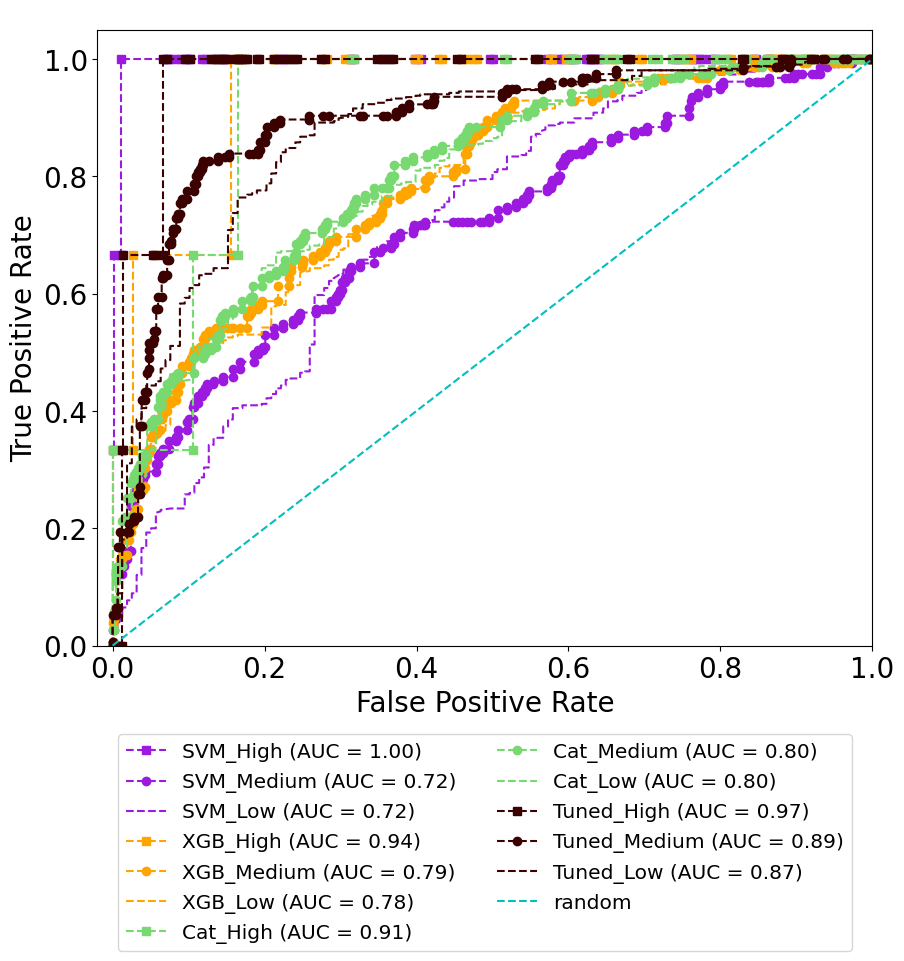

In [88]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import MultiLabelBinarizer

def multilab_roc(y_test,y_score,color,num_labels,label):

    ls = ['s','o',' ']
    #Binarize labels
    lab = y_test.tolist()
    lab =[str(i) for i in lab]
    mlb = MultiLabelBinarizer()
    y_test_bin = mlb.fit_transform(lab)
    
    # Compute ROC & AUC
    fpr =dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_labels):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i],tpr[i])
    
    # plot the figure
    for i in range(num_labels):
        plt.plot(fpr[i], tpr[i],f'{color}',marker = f'{ls[i]}',linestyle='--',label=label[i] + ' (AUC = %0.2f)' % roc_auc[i])
        #plt.legend(loc="lower right")



plt.figure(figsize=(10,8))
multilab_roc(y_test,out_1_p,'#9C19E0',num_labels=3,label = ['SVM_High','SVM_Medium','SVM_Low'])
multilab_roc(y_test,out_2_p,'orange',num_labels=3,label = ['XGB_High','XGB_Medium','XGB_Low'])
multilab_roc(y_test,out_3_p,'#77D970',num_labels=3,label = ['Cat_High','Cat_Medium','Cat_Low'])
multilab_roc(y_test,out_4_p,'#3B0000',num_labels=3,label = ['Tuned_High','Tuned_Medium','Tuned_Low'])

plt.plot([0, 1], [0, 1], 'c--',label='random')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=20)
plt.ylabel('True Positive Rate', size=20)
plt.xticks(size=20),plt.yticks(size=20)
plt.title(' ')
plt.legend(bbox_to_anchor=(0.5, -0.32),loc="center",ncol=2,prop={'size': 14.5})
plt.savefig('model/NLP_tokenized/fig/ref_models_hemo_roc_3L.tiff',dpi=600,bbox_inches='tight')
plt.show()

### Confusion Matrix

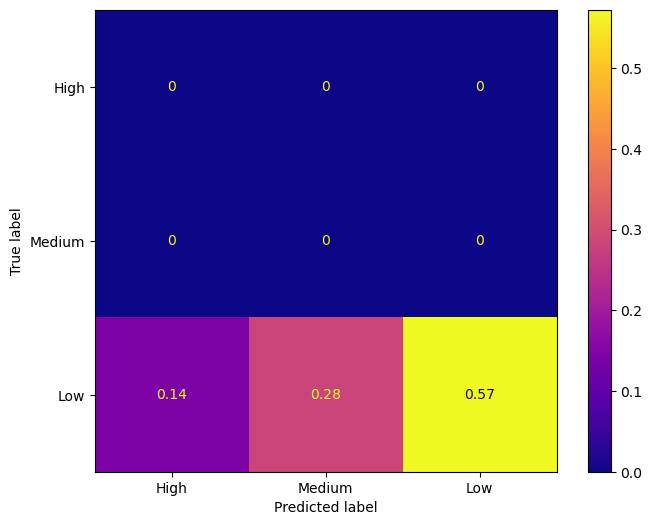

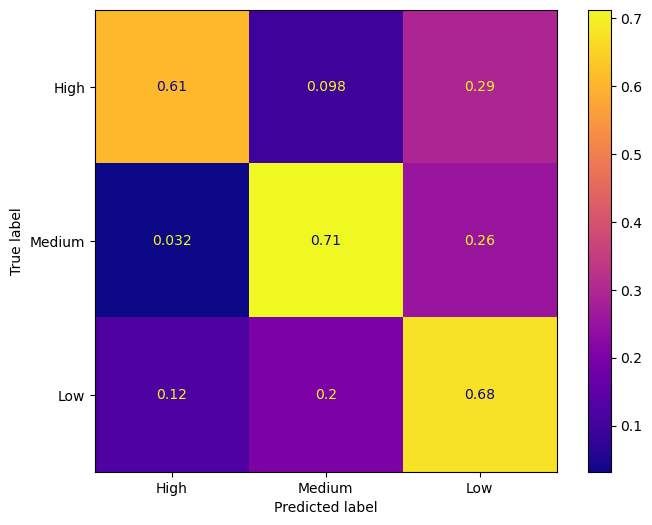

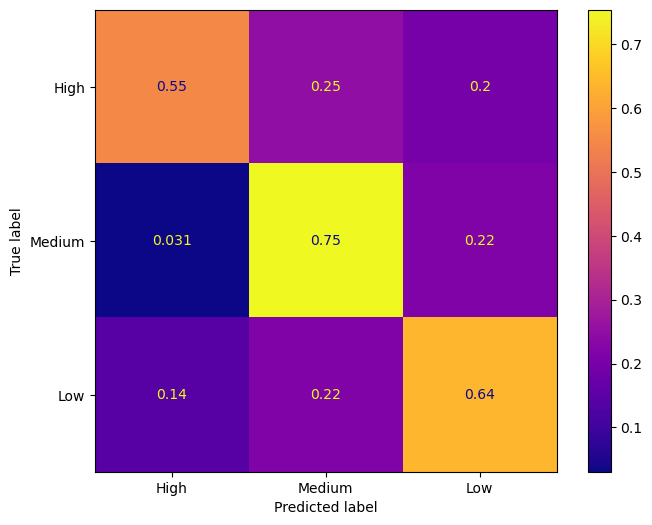

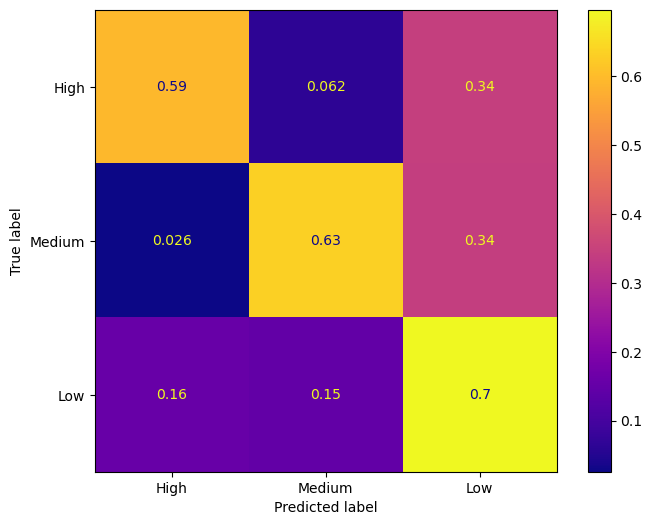

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

fig,ax = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay.from_predictions(out_1,y_test,ax=ax,cmap = 'plasma', normalize='true')
ax.xaxis.set_ticklabels(['High','Medium','Low'])
ax.yaxis.set_ticklabels(['High','Medium','Low'])
#plt.savefig('fig/clf_1_cm.png',dpi=600)
plt.savefig('model/NLP_tokenized/fig/SVM_hemo_cm_3L.png',dpi = 600)

fig,ax = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay.from_predictions(out_2,y_test,ax=ax,cmap = 'plasma', normalize='true')
ax.xaxis.set_ticklabels(['High','Medium','Low'])
ax.yaxis.set_ticklabels(['High','Medium','Low'])
plt.savefig('model/NLP_tokenized/fig/XGBT_hemo_cm_3L.png',dpi = 600)

fig,ax = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay.from_predictions(out_3,y_test,ax=ax,cmap = 'plasma', normalize='true')
ax.xaxis.set_ticklabels(['High','Medium','Low'])
ax.yaxis.set_ticklabels(['High','Medium','Low'])
plt.savefig('model/NLP_tokenized/fig/cat_hemo_cm_3L.png',dpi = 600)

fig,ax = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay.from_predictions(out_4,y_test,ax=ax,cmap = 'plasma', normalize='true')
ax.xaxis.set_ticklabels(['High','Medium','Low'])
ax.yaxis.set_ticklabels(['High','Medium','Low'])
plt.savefig('model/NLP_tokenized/fig/Tuned_hemo_cm_3L.png',dpi = 600)

# for predicting

In [1]:
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn import preprocessing
from Bio.SeqUtils.ProtParam import ProteinAnalysis

torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4080'

In [25]:
#from transformers import AutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("Rostlab/prot_bert",num_labels=2,output_attentions=False)
model_state_dict = torch.load('model/aasp_hemo_tuned_protbert_bin_EPC20.pth')
model.load_state_dict(model_state_dict, strict=False)

def process(txt):
  split = ' '.join(txt)
  return split
print('model loaded for prediction')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Rostlab/prot_bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mdlab_2\AppData\Local\Temp\ipykernel_10020\2194226087.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serial

model loaded for prediction


In [5]:
in_data = pd.read_excel('mel_lib_references.xlsx',sheet_name = 'Sheet2')
in_data.head()

,CODE,SEQ
0,mel_hexa_0,GFLSIL
1,mel_hexa_1,FLSILK
2,mel_hexa_2,LSILKK
3,mel_hexa_3,SILKKV
4,mel_hexa_4,ILKKVL


In [27]:
from modlamp.sequences import Helices
from modlamp.plot import helical_wheel

H = Helices(100, 6, 10)
H.generate_sequences()
seq = H.sequences

In [29]:
#input_sequence = in_data.SEQ.tolist()
#input_sequence = ['FFLSILKKR','FFLSLKKR','FKLLFLL','VKSLKI','KLLFSI']
input_sequence = seq

sequence = []
for i in range(len(input_sequence)):
    p = process(input_sequence[i])
    sequence.append(p)
gravy = [ProteinAnalysis(s).gravy() for s in input_sequence]
#print(sequence)
#print('gravy idx. :' ,gravy)

In [31]:
model.to('cuda')
model.eval()

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
encoded_data = tokenizer.batch_encode_plus(sequence,return_attention_mask=True,padding=True,return_tensors='pt').to('cuda')
input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']

with torch.no_grad():
        outputs =  model(input_ids,attention_mask=attention_masks)
        predictions = torch.argmax(outputs[0],dim=1).flatten()
        
logits = outputs.logits
probabilities = F.softmax(logits, dim=-1)
#print(probabilities[:,0])

#class_names = ["High", "Medium", "Low"]
#gravy = [ProteinAnalysis(s).gravy() for s in seqs]
class_names = ["High", "Low"] 
final_labels = [class_names[i] for i in predictions]
print('predicted AMP class :', final_labels,
      '\nAMP probability score:', probabilities[:,0].cpu().numpy())

predicted AMP class : ['High', 'High', 'High', 'Low', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'Low', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'Low', 'High', 'High', 'High', 'High', 'High', 'Low', 'Low', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High'] 
AMP probability score: [0.9734061  0.9736006  0.9750079  0.27959424 0.9430043  0.97376966
 0.9728874  0.9739421  0.9752245  0.68935716 0.974064   0.973489
 0.97306305 0.9353187  0.9

In [11]:
predicted = pd.DataFrame()
predicted['Sequence'] = input_sequence
predicted['class'] = final_labels
predicted['p score'] = probabilities[:,0].cpu().numpy()

predicted.to_csv('predictions/mel_lib_ref_ML_prediction_hemo.csv')
predicted.head()

,Sequence,class,p score
0,GFLSIL,High,0.934866
1,FLSILK,High,0.974564
2,LSILKK,High,0.960784
3,SILKKV,High,0.972090
4,ILKKVL,High,0.969770


In [9]:
import torch.nn.functional as F
logits = outputs.logits
probabilities = F.softmax(logits, dim=-1)
print(probabilities[:,0])
#print(outputs)

tensor([0.9766], device='cuda:0')


In [20]:
from transformers import BertTokenizer, BertForMaskedLM

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert")
model = BertForMaskedLM.from_pretrained("Rostlab/prot_bert")
model_state_dict = torch.load('model/aasp_hemo_tuned_protbert_bin_EPC20.pth')

input_text = "A S D"
encoded_input = tokenizer(input_text, return_tensors="pt")

output = model.generate(encoded_input["input_ids"],num_beams=3,early_stopping=True,max_length=11)
generated_sentence = tokenizer.decode(output[0],skip_special_tokens=True)

print(generated_sentence)

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'c

A S D K K K K K K
